In [1]:
import pandas as pd
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import time
from scipy.stats import f_oneway
from scipy.stats import pearsonr

In [2]:
time.ctime().replace(' ', '_')

'Mon_Mar__4_15:09:43_2019'

In [3]:
def ability_level_mapper(data, groups=None, col='front', how='naive', n_level=19, invert=True,
                         parameters=None,target_col_name='performance'):
    # the raw data is divided into groups according to its exc_num, ability levels are calculated respectively
    # how: 1 is mapping without any other processing, called 'naive'
    origin = data.copy()
    
    if parameters is not None:
        col, how, n_level, invert, v_max, v_min = parameters
        interval = (v_max- v_min)/n_level
        assert interval!=0, 'zero dividend'
        origin[target_col_name] = (origin[col]-v_min)/interval
        
        origin[target_col_name] = origin[target_col_name].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[target_col_name]+1
        else:
            origin[target_col_name] = origin[target_col_name]+1
        
        return origin, parameters
        
    if groups == None:
        v_max = origin[col].max()
        v_min = origin[col].min()
        
        interval = (v_max- v_min)/n_level
        assert interval!=0, 'zero dividend'
        origin[target_col_name] = (origin[col]-v_min)/interval
        
        origin[target_col_name] = origin[target_col_name].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[target_col_name]+1
        else:
            origin[target_col_name] = origin[target_col_name]+1
        
        parameters = (col, how, n_level, invert, v_max, v_min )
        return origin, parameters
    
    if how == 1 or how=='naive':
        tmp = origin[col]
        for index, group in groups:
            
            v_max = group[col].max()
            v_min = group[col].min()
            
            interval = (v_max-v_min)/n_level
            
            assert interval!=0, 'zero dividend'
            
            origin.loc[index, col] = (origin.loc[index, col]-v_min)/interval
        origin[col] = origin[col].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[col]+1
            
        else:
            origin[target_col_name] = origin[target_col_name]+1
        origin[col] = tmp
        parameters = (col, how, n_level, invert, v_max, v_min )
        del tmp
        return origin, parameters

def cMGRM(theta, alpha=1.5, b=0.5, c=0):
    # MGRM cumulative probability
    return math.e**(alpha*(theta-b+c))/(1+math.e**(alpha*(theta-b+c)))

def cMGRM_df(data, c):
    if 'gamma' in data.columns:
        return math.e**(data['alpha']*(data['theta']-data['b']+data['gamma']*c))/ \
            (1+math.e**(data['alpha']*(data['theta']-data['b']+data['gamma']*c)))
    
    if 'm' in data.columns:
        return math.e**(data['alpha']*(data['m']*data['theta']-data['b']+c))/ \
            (1+math.e**(data['alpha']*(data['m']*data['theta']-data['b']+c)))
    return math.e**(data['alpha']*(data['theta']-data['b']+c))/ \
                (1+math.e**(data['alpha']*(data['theta']-data['b']+c)))

def cMGRM_user_df(data, theta, c):
    # Matrix operation
    return math.e**(data['alpha']*(theta-data['b']+c))/(1+math.e**(data['alpha']*(theta-data['b']+c)))

def cMGRM_exc_df(data, alpha, b, c):
    # Matrix operation
    return math.e**(alpha*(data['theta']-b+c))/(1+math.e**(alpha*(data['theta']-b+c)))

def model(theta, alpha, b, cl=[1,0,-0.6], start=1):
    sum = start*1
    for c in cl:
        sum += cMGRM(theta, alpha, b, c)
    return sum

def model_df(data, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
#     print(data)
    for c in cl:
        sum+= cMGRM_df(data, c)
#         print(c)
#         print(cMGRM_df(data, c))
#     stop
        assert not sum.isnull().values.any(), 'na exists'
    return sum

def model_user_df(data, theta, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_user_df(data, theta, c)
    return sum

def model_exc_df(data, alpha, b, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_exc_df(data, alpha, b, c)
        
    return sum

def partial_derivative_model_alpha2_b2_df(data, alpha, b, cl):
    # partial derivative of model to alpha
    
    g_alpha = 0
    g_b = 0
    
    
    for c in cl:
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(-data['theta']+b-c)
        g_alpha += curr
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(alpha)
        g_b += curr
        
    return g_alpha, g_b

def partial_derivative_model_alpha2_b2_df2(data, cl, regular_term=True, zoom_factor=0.1, 
                                           max_thres=1000, verbose=False):
    # partial derivative of model to alpha
    
    g_alpha = 0
    g_b = 0
    g_gamma = 0
    g_m = 0
    regular_term_alpha = 0
    regular_term_b = 0
    
    for c in cl:
        if 'gamma' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['theta']-data['b']+data['gamma']*c)
            g_alpha += curr
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*c
            g_gamma += curr
        elif 'm' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['m']*data['theta']-data['b']+c)
            g_alpha += curr
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*data['theta']
            g_m += curr
        else:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['theta']-data['b']+c)
            g_alpha += curr
            
        curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(-data['alpha'])
        g_b += curr
#     print(g_b)
#     assert g_b.mean()<0.05, 'too small partial derivative'
    if regular_term:
        for c in cl:
            #regular_term_alpha += zoom_factor*data['alpha']*(data['theta']-data['b']+c)**2  
            regular_term_alpha -= zoom_factor*data['alpha']
            #regular_term_b -= zoom_factor*data['alpha']**2*(data['theta']-data['b']+c)
            regular_term_b -= zoom_factor*data['b']
                 
                #+zoom_factor*(data['theta']-data['b']+c)**-3
            
    if verbose:
        print('----------partial_derivative_model_alpha2_b2_df2----------')
        print('derivative of alpha: ', g_alpha)
        if regular_term:
            print('regular term of alpha: \n')
            print(regular_term_alpha)
            
        print('derivative of b: ', g_b)
        if regular_term:
            print('regular term of b: \n')
            print(regular_term_b)
            
#         print('derivative of gamma:', g_gamma)
            
    g_alpha += regular_term_alpha
    g_b += regular_term_b
    g_alpha *= zoom_factor
    g_b *= zoom_factor
    
    g_alpha[g_alpha>max_thres] = max_thres
    g_alpha[g_alpha<-max_thres] = -max_thres
    g_b.loc[g_b>max_thres] = max_thres
    g_b.loc[g_b<-max_thres] = -max_thres
    
    if 'gamma' in data.columns:
        g_gamma.loc[g_gamma>max_thres] = max_thres
        g_gamma.loc[g_gamma<-max_thres] = -max_thres
        return g_alpha, g_b, g_gamma
    if 'm' in data.columns:
        g_m.loc[g_m>max_thres] = max_thres
        g_m.loc[g_m<-max_thres] = -max_thres
        return g_alpha, g_b, g_m
    
    return g_alpha, g_b



def partial_derivative_model_theta2_df(data, theta, cl):
    # partial derivative of model to theta
    g_theta = 0
    for c in cl:
        curr = cMGRM_user_df(data,theta, c)*(1-cMGRM_user_df(data,theta, c))*(-data['alpha'])
        g_theta += curr
     
    return g_theta

def partial_derivative_model_theta2_df2(data, cl, regular_term=True, zoom_factor=0.1, max_thres=1000,
                                       verbose=False):
    # partial derivative of model to theta
    g_theta = 0
    regular_term_theta = 0
    
    for c in cl:
        if 'm' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*data['m']
        else:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['alpha'])
        g_theta += curr
#     print(g_theta)
#     assert g_theta.mean()>0.1, 'too small partial derivative'
        
        
    if regular_term:
        for c in cl:
            # regular_term_theta += zoom_factor*data['alpha']**2*(data['theta']-data['b']+c) 
            # - zoom_factor*(data['theta']-data['b']+c)**-3
            regular_term_theta -= zoom_factor*data['theta']
    
    if verbose:
        print('--------partial_derivative_model_theta2_df2----------')
        print('derivative of theta: \n')
        print(g_theta)
        if regular_term:
            print('regular term of theta: \n')
            print(regular_term_theta)
            
    
    g_theta += regular_term_theta
    g_theta *= zoom_factor       
    g_theta[g_theta>max_thres] = max_thres
    g_theta[g_theta<-max_thres] = -max_thres
    return g_theta

def constraint_theta(data, parameters, cl, item_by=['difficulty'], 
                     user_by=['uid', 'day', 'exc_num', 'exc_times'], 
                     zoom_factor=0.01, max_thres=500):
    """
    this function is used to calculate partial derivative for theta in the fomula 
    min sum((theta-b+(c_k+c_(k+1))/2)**2)
    """
    
    uid_p, exc_p = parameters
    # combine parameter and data
    tmp = data.merge(exc_p, on=item_by, how='left')
    tmp = tmp.merge(uid_p, on=user_by, how='left')
#     print(tmp.head())
    # calc paritial derivative
    if 'gamma' in exc_p.columns:
        tmp['g_theta'] =  tmp['theta']-tmp['b']+tmp['gamma']*tmp['cl_term']
    else:
        tmp['g_theta'] =  tmp['theta']-tmp['b']+tmp['cl_term']
    gradient_theta = tmp[user_by+['g_theta']].groupby(user_by).sum()*2
    gradient_theta = gradient_theta.reset_index()
    gradient_theta.columns = user_by+['theta']
    gradient_theta['theta'] *= zoom_factor
    
    gradient_theta.loc[gradient_theta['theta']>max_thres, 'theta'] = max_thres
    gradient_theta.loc[gradient_theta['theta']<-max_thres, 'theta'] = -max_thres
    
    return gradient_theta

def constraint_b(data, parameters, cl, item_by=['difficulty'], 
                     user_by=['uid', 'day', 'exc_num', 'exc_times'], 
                 zoom_factor=0.01, zoom_factor_gamma=0.001, max_thres=500):
    """
    this function is used to calculate partial derivative for theta in the fomula 
    min sum((theta-b+(c_k+c_(k+1))/2)**2)
    """
    
    uid_p, exc_p = parameters
    # combine parameter and data
    tmp = data.merge(exc_p, on=item_by, how='left')
    tmp = tmp.merge(uid_p, on=user_by, how='left')
#     print(tmp.head())
    # calc paritial derivative
    if 'gamma' in exc_p.columns:
        tmp['g_b'] =  -tmp['theta']+tmp['b']-tmp['gamma']*tmp['cl_term']
        tmp['g_gamma'] = (tmp['theta']-tmp['b']+tmp['gamma']*tmp['cl_term'])*tmp['cl_term']
        gradient_b = tmp[item_by+['g_b', 'g_gamma']].groupby(item_by).sum()*2
        
    else:
        tmp['g_b'] =  -tmp['theta']+tmp['b']-tmp['cl_term']
        gradient_b = tmp[item_by+['g_b']].groupby(item_by).sum()*2
        
        
    gradient_b = gradient_b.reset_index()
    
    if 'gamma' in exc_p.columns:
        gradient_b.columns = item_by+['b', 'gamma']
        gradient_b['gamma'] *= zoom_factor_gamma
    else:
        gradient_b.columns = item_by+['b']
        
    gradient_b['b'] *= zoom_factor
    gradient_b['alpha'] = 0
    
    if 'gamma' in exc_p.columns:
        gradient_b.loc[gradient_b['gamma']>max_thres, 'gamma'] = max_thres
        gradient_b.loc[gradient_b['gamma']<-max_thres, 'gamma'] = -max_thres
   
    gradient_b.loc[gradient_b['b']>max_thres, 'b'] = max_thres
    gradient_b.loc[gradient_b['b']<-max_thres, 'b'] = -max_thres
    
    return gradient_b


def loss(theta, alpha, b, cl, y):
    return (model(theta, alpha, b, cl)-y)**2

def sum_loss(data, parameters, cl, theta_by=['uid','day','exc_num','exc_times'], item_by=['difficulty'], 
             verbose=False):
    uid_p, exc_p = parameters
    tmp = data.copy()
    tmp = tmp.merge(uid_p, on=theta_by)
    tmp = tmp.merge(exc_p, on=item_by)
    exp = model_df(tmp, cl)
    tmp['diff'] = exp-tmp['performance']
    
    if verbose:
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='exc_num', y='diff', data=tmp)
        plt.show()

        print(tmp['diff'].describe())
        print('\n\n')
        print('max')
        mx = tmp[tmp['diff']==tmp['diff'].max()]
        mx = mx.reset_index(drop=True)
        if len(mx)>1:
            mx = mx.loc[0,]
        print(mx)
        print('\n')
        print(tmp.set_index(theta_by).loc[mx[theta_by].values.tolist()].describe())
        print('\n\n')
        print('min')
        mi = tmp[tmp['diff']==tmp['diff'].min()]
        mi = mi.reset_index(drop=True)
        if len(mi)>1:
            mi = mi.loc[0, ]

        print(mi)
        print('\n')
        print(tmp.set_index(theta_by).loc[mi[theta_by].values.tolist()].describe())

        print('\n\n')
        print('std')
        std = tmp.groupby(theta_by)['diff'].std().reset_index()
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='exc_num', y='diff', data=std)
        plt.show()

        print('\n\n')
        print('std theta')
        theta_std = tmp.groupby(['uid', 'day', 'exc_num'])['theta'].std().reset_index()
        days = theta_std['day'].unique()
        for day in days:
            print(day)
            sns.set_style('whitegrid')
            f, ax= plt.subplots(figsize = (14, 10))
            ax = sns.boxplot(x='uid', y='theta', data=theta_std[theta_std['day']==day])
            plt.show()
            print('\n')

        print('\n\n')
        print('mean theta')
        theta_mean = tmp.groupby(['uid', 'day', 'exc_num'])['theta'].mean().reset_index()
        days = theta_mean['day'].unique()
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='uid', y='theta', hue='day', data=theta_mean)
        plt.show()
        print('\n')
    
    tmp['diff'] = tmp['diff']**2
    s = np.sum(tmp['diff'])
    mean = np.mean(tmp['diff'])
    
    del tmp
    return s, mean

def calc_gradient_user(data, parameters, cl, theta_by=['uid','day','exc_num','exc_times'], 
                       item_by=['difficulty'], zoom_factor=0.1, regular_term=True, verbose=False):
    # calc sum loss for a certain user, so we select all loss by this user
    gradient_theta = pd.DataFrame()
    uid_p, exc_p = parameters
    
    # groups will be seperate by ability definitions
#     groups = data.groupby(theta_by)
#     check_theta = uid_p.set_index(theta_by)
    assert len(data) == len(data.drop_duplicates()), \
    'maybe the expected value for each difficulty in each exercise repetition should be calculated first'
    
    gradient_theta = data.copy()
    gradient_theta = gradient_theta.merge(uid_p, on=theta_by)
    gradient_theta = gradient_theta.merge(exc_p, on=item_by)
    gradient_theta['ev'] = model_df(gradient_theta, cl)
    gradient_theta['g_theta'] = partial_derivative_model_theta2_df2(gradient_theta, cl, zoom_factor=zoom_factor,
                                                                    regular_term=regular_term,
                                                                   verbose=verbose)
    gradient_theta['g_theta'] = (gradient_theta['ev']-gradient_theta['performance'])*gradient_theta['g_theta']
    gradient_theta = gradient_theta[theta_by+['g_theta']].groupby(theta_by).sum()*2
    gradient_theta = gradient_theta.reset_index()
    gradient_theta.columns = theta_by+['theta']
    
#     for index, group in groups:
#         # calculate the expected value with current estimated theta for each item
#         # here item means the moment in one exercise with some difficulty
#         theta = check_theta.loc[index, 'theta']
#         difficulties = group['difficulty'].unique()
#         exc_parameters = exc_p.set_index(item_by).loc[difficulties].reset_index()
#         expected_value = model_user_df(exc_parameters, theta=theta, cl=cl)
#         y = group.loc[:, 'performance'].reset_index(drop=True)
#         difficulties2 = group.loc[:, 'difficulty'].tolist()
#         assert difficulties.tolist()==difficulties2, 'false alignment between expected value and average value'
#         diff = expected_value-y
#         g_theta = partial_derivative_model_theta2_df(exc_parameters, theta, cl)
#         g_theta = 2*np.sum(diff*g_theta)


#         curr = pd.DataFrame(np.array(list(index)+[g_theta]).reshape(1,-1), columns=theta_by+['theta'])
#         gradient_theta = pd.concat([gradient_theta, curr])
        
     
#     gradient_theta = gradient_theta.reset_index(drop=True)
#     del check_theta
#     del groups
#     print(gradient_theta)
    return gradient_theta

def calc_gradient_exc(data, parameters, cl, theta_by=['uid','day','exc_num','exc_times'], 
                      item_by=['difficulty'], zoom_factor=0.1, regular_term=True, verbose=False):
    # calc sum loss for a certain exercise, so we select all loss by this exercise
    gradient_alpha_b = pd.DataFrame()
    uid_p, exc_p = parameters
    assert len(data) == len(data.drop_duplicates()), \
    'maybe the expected value for each difficulty in each exercise repetition should be calculated first'
    
    gradient_alpha_b = data.copy()
    gradient_alpha_b = gradient_alpha_b.merge(uid_p, on=theta_by)
    gradient_alpha_b = gradient_alpha_b.merge(exc_p, on=item_by)
#     print(1)
#     print(gradient_alpha_b)
    gradient_alpha_b['ev'] = model_df(gradient_alpha_b, cl)
    if 'gamma' in exc_p.columns:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'], gradient_alpha_b['g_gamma'] = \
            partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)
    elif 'm' in exc_p.columns:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'], gradient_alpha_b['g_m'] = \
            partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)
    else:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'] = partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)

    # The sign of the gradient is decided by partial derivative model
    gradient_alpha_b['g_alpha'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance']) \
        *gradient_alpha_b['g_alpha']
    
    gradient_alpha_b['g_b'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])*gradient_alpha_b['g_b']
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b['g_gamma'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])* \
            gradient_alpha_b['g_gamma']
    if 'm' in exc_p.columns:
        gradient_alpha_b['m'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])* \
            gradient_alpha_b['m']
        
    gradient_alpha_b['diff'] = gradient_alpha_b['ev']-gradient_alpha_b['performance']
#     print(find_segment(gradient_alpha_b, ['uid', 'day', 'exc_num', 'exc_times'], [1, 3, 3.2, 1]))
#     print(find_segment(gradient_alpha_b, ['uid', 'day', 'exc_num', 'exc_times'], [1, 5, 3.2, 2]))
#     stop()
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b', 'g_gamma']].groupby(item_by).sum()*2
    elif 'm' in exc_p.columns:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b', 'g_m']].groupby(item_by).sum()*2
    else:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b']].groupby(item_by).sum()*2
        
        
    gradient_alpha_b = gradient_alpha_b.reset_index()
    
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b.columns = item_by+['alpha', 'b', 'gamma']
    elif 'm' in exc_p.columns:
        gradient_alpha_b.columns = item_by+['alpha', 'b', 'm']
    else:
        gradient_alpha_b.columns = item_by+['alpha', 'b']
        
        
    return gradient_alpha_b

def calc_ANOVA(df, pos1, pos2, target_col, by=['uid', 'day', 'exc_num']):
    tmp = df.set_index(by)
    group1 = tmp.loc[tuple(pos1),target_col]#.reset_index()
    group2 = tmp.loc[tuple(pos2), target_col]#.reset_index()
    
    f_value, p_value = f_oneway(group1, group2)
    return f_value, p_value
    
    

def combine_data_cl(data, cl, del_min_max=True):
    """
    del_min_max:    if True, delete performance with 1 and len(cl), then they will not be 
                    considered for optimization
    """
    if del_min_max:
        data = data[data['performance']!=1]
        data = data[data['performance']!=len(cl)+1]
    else:
        data['cl_term'] = 0
        data.loc[(data.performance==1) | (data.performance==len(cl)+1), 'cl_term'] = np.nan
    for i in xrange(len(cl)-1):
        data.loc[data.performance==i+2, 'cl_term'] = (cl[i]+cl[i+1])/2
        
    return data

def calc_test_theta(df, cl, exc_p, user_by= ['uid', 'day', 'exc_num', 'exc_times'],
                    item_by=['difficulty'], how='practical', real_time=False, **params):
    """
    df:    input data, maybe online data
    """
    
    if how=='extremum':
        """
        this method only consider the moment status(ability)
        """
        cols = df.columns+['theta']
        df = df.merge(exc_p, on=item_by, how='left')
        df['theta'] = np.nan
        df.loc[df.performance==1, 'theta'] = -4
        df.loc[df.performance==len(cl), 'theta'] = 4
        tmp =  df.loc[(df.performance>1) & (df.performance<len(cl)), ['theta', 'b', 'performance']].reset_index()
        tmp['performance'] = tmp['performance'].astype(int)

        for i in xrange(len(cl)-1):
            tmp.loc[tmp.performance==i+2, 'theta'] = tmp.loc[tmp.performance==i+2, 'b']-(cl[i]+cl[i+1])/2

        tmp = tmp.set_index(['index'])
        df.loc[(df.performance>1) & (df.performance<len(cl)), 'theta'] = tmp['theta']
        return df
    elif how=='practical':
        """
        this method consider the historical data
        length:      how long data will be taken for the estimation
        """
        result = []
        df_tmp = pd.DataFrame()
        l = params['length']
        cadidates = np.linspace(-4, 4, 100)
        avg = df.groupby(user_by+item_by).mean()['performance'].reset_index()
        avg = avg.merge(exc_p, on=['difficulty'], how='left')
        avg['result'] = 0
        avg['min_loss'] = 10000
        for ca in cadidates:
            avg['theta'] = ca
            avg['exp'] = model_df(avg, cl)
            avg['loss'] = (avg['exp']-avg['performance'])**2
            avg['loss'] = avg.groupby(['uid', 'day', 'exc_num', 'exc_times'])['loss'].cumsum()
            avg.loc[avg.loss<avg.min_loss, 'result'] = ca
            avg.loc[avg.loss<avg.min_loss, 'min_loss'] = avg.loc[avg.loss<avg.min_loss, 'loss']
        
        df_tmp = avg[user_by+['result']]
        df_tmp = df_tmp.groupby(user_by).tail(1)
#         print(df_tmp)
        df_tmp.columns = user_by+['theta']
#         for index, group in avg.groupby(user_by):            
#             min_loss = 10000
#             theta = None
#             for ca in cadidates:
#                 group['theta'] = ca
#                 exp = model_df(avg, cl)
#                 loss = (exp-avg['performance'])**2
#                 loss = loss.sum()
                
#                 if loss<min_loss:
#                     min_loss = loss
#                     theta = ca
#             curr = pd.DataFrame(np.array(list(index)+[theta]).reshape(1,-1), columns=user_by+['theta'])
#             df_tmp = pd.concat([df_tmp, curr])
                    
#             result.append(theta)
        
        return df_tmp
#     elif how=='practical2':
        
        
        


def update(parameter, gradient, alpha=0.001):
    uid_p, exc_p = parameters
    uid_gradient, exc_gradient = gradient
    
    # calc average theta gradient by each user in each day
    uid_avg = uid_gradient.groupby(['uid', 'day']).mean()    
    # calc average alpha and b by each exercise
    exc_avg = exc_gradient.groupby(['exc_num']).mean()
    
    uid_step = uid_avg*alpha
    exc_step = exc_avg*alpha
    
    uid_result = pd.concat([uid_p.set_index(['uid', 'day']), uid_step], join='inner', axis=1)
    exc_result = pd.concat([exc_p.set_index(['exc_num']), exc_step], join='inner', axis=1)
    
    uid_result['theta'] -= uid_result['theta_g']
    exc_result['alpha'] -= exc_result['alpha_g']
    exc_result['b'] -= exc_result['b_g']
    
    return [uid_result.reset_index()[['uid', 'day', 'theta']], exc_result.reset_index()[['exc_num', 'alpha', 'b']]]

def update2(parameters, optimizer_uid, optimizer_exc, theta_by=['day','uid','exc_num','exc_times'],
           item_by=['difficulty'], a_lower_limit=10**-8):
    uid_p, exc_p = parameters
    uid_p = uid_p.set_index(theta_by) - optimizer_uid.set_index(theta_by)
    exc_p = exc_p.set_index(item_by) - optimizer_exc.set_index(item_by)
    uid_p.loc[uid_p.theta>10, 'theta'] = 10
    uid_p.loc[uid_p.theta<-10, 'theta'] = -10
    exc_p.loc[exc_p.alpha>10, 'alpha'] = 10
    exc_p.loc[exc_p.alpha<0, 'alpha'] = a_lower_limit
#     exc_p.loc[exc_p.b>10, 'b'] = 10
#     exc_p.loc[exc_p.b<-10, 'b'] = -10
    return uid_p.reset_index(), exc_p.reset_index()


def merge_minority(data, by=['difficulty'],threshold=10):
    cnt = 1
    while cnt>0:
        cnt = 0
        for index, group in data.groupby(by):
            d = index
            if len(group)<threshold:
                if d<data['difficulty'].max()/2:
                    data.loc[data.difficulty==d, 'difficulty'] +=1
                else:
                    data.loc[data.difficulty==d, 'difficulty'] -=1
                cnt += 1
    return data       
    
def initial_parameters(data, uid_by=['uid', 'day', 'exc_num', 'exc_times'], 
                       exc_by=['difficulty'], with_gamma=True, with_m=True):
    uid_cols = uid_by+['theta']
    
    
    if with_gamma:
        exc_cols = exc_by+['alpha', 'b', 'gamma']
    elif with_m:
        exc_cols = exc_by+['alpha', 'b', 'm']
    else:
        exc_cols = exc_by+['alpha', 'b']
        
        
    uid_p = pd.DataFrame(np.array([]).reshape(0, len(uid_cols)), columns=uid_cols)
    exc_p = pd.DataFrame(np.array([]).reshape(0, len(exc_cols)), columns=exc_cols)
    
    # compare average score over all difficulty of different user
    avg_perf = data[['uid', 'performance']].groupby(['uid']).mean().reset_index()
    
    # transform average score in range of [-3, 3]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['theta'] = (avg_perf['performance']-min_perf)/interval*6-3
    avg_perf = avg_perf.drop_duplicates()
    
    tmp = data[['uid', 'day', 'exc_num', 'exc_times', 'performance']].groupby(uid_by) 
    
    for index,group in tmp:
        uid, _, _, _ = index
        
        curr = pd.DataFrame(np.array(list(index)+[0]).reshape(1, 5), 
                            columns=uid_cols)
        curr['theta'] = avg_perf.loc[avg_perf.uid==uid, 'theta'].tolist()[0]
        uid_p = pd.concat([uid_p, curr])
        
    
    #################################
    # compare average score over all user of different exercises
    avg_perf = data[['difficulty', 'performance']].groupby(exc_by).mean()
    
    
    # use average score to represent exercise difficulty, and transform them in range of [-2, 2]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['b'] = (avg_perf['performance']-min_perf)/interval*4-2
    avg_perf['b'] = avg_perf['b']*-1
    
    avg_perf = avg_perf.reset_index()
#     avg_perf['alpha'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    avg_perf['alpha'] = 1
    
    if with_gamma:
        avg_perf['gamma'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    if with_m:
        avg_perf['m'] = 1
    
    exc_p = avg_perf[exc_cols]
    uid_p = uid_p.reset_index(drop=True)
    exc_p = exc_p.reset_index(drop=True)
    
    return uid_p, exc_p
    
    
def select_exc(data, selected_excs=None, non_selected_excs=None, selected_diff=None,
               non_selected_diff=None, selected_uid=None, non_selected_uid=None, delete=None):
    data = data.set_index(['exc_num'])  
    if selected_excs is not None:
        data = data.loc[selected_excs]
    if non_selected_excs is not None:
        data = data.reset_index()
        for e in non_selected_excs:
            data = data.loc[data.exc_num!=e]
            
    data = data.reset_index()
    data = data.set_index(['difficulty'])
    if selected_diff is not None:
        data = data.loc[selected_diff]
    if non_selected_diff is not None:
        data = data.reset_index()
        for diff in non_selected_diff:
            data = data.loc[data.difficulty!=diff]
            
    data = data.reset_index()
    data = data.set_index(['uid'])       
    if selected_uid is not None:
        data = data.loc[selected_uid]
    if non_selected_uid is not None:
        data = data.reset_index()
        for uid in non_selected_uid:
            data = data.loc[data.uid!=uid]
    return data.reset_index()

def set_cl(n=19, start=-1, end=1, test_col_p=None):
    if test_col_p is None:
        return list(np.linspace(start, end, n))
    # if test column is segmented in different length, the c list should have the same distributiion
    else:
        cl = []
        lth = end-start
        # test_col_p denotes the percentage of each point in the whole scale
        # e.g. [0, 0.05, 0.10, ..., 1]
        for percent in test_col_p:
            cl.append(lth*percent+start)
        return cl

def learning_rate_optimizer(gradient, history, cols, how='SGD-M', **params):
    """
    history: previous monontums
    """
    if type(history) is not list:
        history = [history]
        
    if how is None:
        """
        input:
        err_thres:    used to check if it is necessary to random a learning rate
        eta:          learning rate
        grad_thres:   whose gradients are too small, and need a random learning rate
        mean_sqr_err: mean loss
        
        output:
        delta:        <DataFrame>
        """
        delta = gradient.copy()
        err_thres = params['err_thres']
        eta = params['eta']
        grad_thres = params['grad_thres']
        mean_sqr_err = params['mean_sqr_err']
        max_step = params['max_step']
        l = len(delta)
        
        assert err_thres>0 and grad_thres>0 and mean_sqr_err>0, 'all parameter should be larger than 0'
        
        for col in cols:
            mean_grad = gradient[col].mean()
            sum_grad = gradient[col].abs().sum()
            proportion = gradient[col].abs()/sum_grad
            delta[col] = gradient[col]*proportion*eta
            
#             if mean_sqr_err>err_thres:
#                 delta.loc[(delta[col]<grad_thres) & (delta[col]>0), col] = pd.Series(np.random.rand(l))
#                 delta.loc[(delta[col]>-grad_thres) & (delta[col]<0), col] = -1*pd.Series(np.random.rand(l))
                
            delta.loc[delta[col]>max_step, col] = max_step
            delta.loc[delta[col]<-max_step, col] = -max_step
        
        assert not delta.isnull().values.any(), 'na exists'
        
        return delta, history
        
    if how == 'SGD-M':
        v_t = 1
        gamma = params['gamma']
        eta = params['eta']
        max_step = params['max_step']
        m_t = gradient
        
        for col, hry in zip(cols, history):
            if len(hry)==0:
                m_t[col] = eta*gradient[col]

            else:
                pre_m = hry[-1]
                m_t[col] = gamma*pre_m[col] + eta*gradient[col]
            hry.append(m_t)
        
            m_t.loc[m_t[col]>max_step, col] = max_step
            m_t.loc[m_t[col]<-max_step, col] = -max_step
        return m_t, history
    
def generate_log(non_selected_cols, selected_cols, non_selected_diff, selected_diff, non_selected_uid,
                selected_uid):
    filename = time.ctime().replace(' ', '_')
    with open('../data/parameter/def_env.p', 'rb') as f:
        tmp = pickle.load(f)
        f.close()
        assert tmp is not None, 'env parameters are none'
    test_col, diff_def, n_class, group, if_del_outlier, if_merge_min, sampleing_rate = tmp
    with open('../data/parameter/'+filename, 'w') as f:
        f.write('test column: '+test_col)
        f.write('\n')
        f.write('difficulty: '+''.join(str(x)+',' for x in diff_def))
        f.write('\n')
        f.write('n_class: '+''.join(str(x)+',' for x in n_class))
        f.write('\n')
        f.write('group: '+''.join(str(x)+',' for x in group))
        f.write('\n')
        f.write('delete outlier in the first stage: '+str(if_del_outlier))
        f.write('\n')
        f.write('if merge minority: '+ str(if_merge_min))
        f.write('\n')
        f.write('sampling rate: '+str(sampleing_rate))
        f.write('\n')
        if selected_cols is not None:
            f.write('selected exercises: '+''.join(str(x)+',' for x in selected_cols))
            f.write('\n')
        if non_selected_cols is not None:
            f.write('non selected exercises: '+''.join(str(x)+',' for x in non_selected_cols))
            f.write('\n')
        if selected_diff is not None:
            f.write('selected difficulty: '+''.join(str(x)+',' for x in selected_diff))
            f.write('\n')
        if non_selected_diff is not None:
            f.write('non selected difficulty: '+''.join(str(x)+',' for x in non_selected_diff))
            f.write('\n')
        if selected_uid is not None:
            f.write('selected uid: '+''.join(str(x)+',' for x in selected_uid))
            f.write('\n')
        if non_selected_uid is not None:
            f.write('non selected uid: '+''.join(str(x)+',' for x in non_selected_uid))
            f.write('\n')
        f.write('\n\n')
        
    return filename

def generate_test(df, n=0, selected=None):
    """
    n: number of user that used as test data
    return:  test data, test uid 
    """
    if n == 0:
        return None, None
    elif selected is not None:
        test_num = []
        assert selected in df['uid'].unique().tolist(), 'invalid uid'
        test = pd.DataFrame()
        if selected is not list:
            selected = [selected]
        for uid in selected:
            tmp = df.loc[df.uid==uid, ]
            test = pd.concat([test, tmp])
        test_num = selected
    else:
        test_num = []
        test = pd.DataFrame()
        uid = df['uid'].unique()
        print(uid)
        for i in xrange(n):
            
            tmp_num = random.randint(1, len(uid))
            if tmp_num>9:
                tmp_num += 1
                tmp_num = uid[tmp_num-2]
            else:
                tmp_num = uid[tmp_num-1]
            test_num.append(tmp_num)
            tmp = df.loc[df.uid==tmp_num, ]
            test = pd.concat([test, tmp])
            
    return test.reset_index(drop=True), test_num

def write_log(mean_loss, sum_loss, filename):
    with open('../data/parameter/'+filename, 'a') as f:
        f.write('mean loss: '+str(mean_loss))
        f.write('\n')
        f.write('sum loss: '+str(sum_loss))
        f.write('\n\n')
        
def get_env_parameters():
    with open('../data/parameter/def_env.p', 'rb') as f:
        tmp = pickle.load(f)
        f.close()
        assert tmp is not None, 'env parameters are none'
    return tmp

def find_segment(df, cols, values):
    tmp = df.copy()
    for col, value in zip(cols, values):
        tmp = tmp[tmp[col]==value]
        
    return tmp

def get_test_col_name(test_col):
    if test_col == 'velocity':
        return 'velocity','velocity'
    elif test_col == 'vd_score':
        return 'score(velocity/deviation)', 'vd_score'
    elif test_col == 'deviation':
        return 'deviation','deviation'
    elif test_col == 'force':
        return 'force', 'force'
    elif test_col == 'tt_freq':
        return 'tremble frequency', 'ff_freq'


In [4]:
all_data = pd.read_csv('../data/step2_expected_performance.csv')
expected_performance = all_data[['day', 'exc_num', 'uid', 'exc_times', 'difficulty','performance']]. \
    groupby(by=['day', 'exc_num', 'uid', 'exc_times', 'difficulty']).mean().reset_index()
print('exercises:', expected_performance['exc_num'].unique())
# expected_performance = expected_performance[expected_performance['day']!=1]
# selected_excs = [1.1, 2.1, 3.1]

with_gamma = False
with_m = True
selected_excs = None
non_selected_excs = None #[1.1, 1.2, 1.3, 1.4, 1.5]
# [2.2, 2.3, 4.1, 4.2, 4.3]
selected_diff = None
non_selected_diff = None #[1, 2, 8 ,10]
test, test_uid = generate_test(expected_performance, 0, None)
selected_uid = None
non_selected_uid = test_uid
expected_performance = select_exc(expected_performance, selected_excs=selected_excs,
                                  non_selected_excs=non_selected_excs, selected_diff=selected_diff,
                                 non_selected_diff=non_selected_diff, selected_uid=selected_uid,
                                 non_selected_uid=non_selected_uid)
print('user index:', expected_performance['uid'].unique())
print('# of course repetitions: ', len(expected_performance.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()))
n_cls = 19
cl = set_cl(n_cls)
all_data = combine_data_cl(all_data, cl, del_min_max=True)
assert len(all_data[all_data['cl_term']==0])==0, 'there is category that is not assigned to a performance'
assert not all_data.isnull().values.any(), 'there is na in the dataframe'
log_name = generate_log(non_selected_excs, selected_excs, non_selected_diff, selected_diff, 
                        non_selected_uid, selected_uid)

exercises: [ 1.1  1.5  2.1  2.2  3.1  3.2  4.1  4.2]
user index: [  1.   2.   4.   5.   6.   7.   3.   8.  10.  11.]
# of course repetitions:  536


In [5]:
# parameters = initial_parameters(expected_performance)
# print(parameters)
# stop()

In [6]:
# cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
#           -0.059, -0.103, -0.156, -0.394, -0.415,
#           -0.478, -1.377, -1.471, -1.989]
# print(len(expected_performance))
# parameters = initial_parameters(expected_performance)
# g_theta = calc_gradient_user(expected_performance, parameters, cl)
# g_alpha_b = calc_gradient_exc(expected_performance, parameters, cl)
# parameters = update2(parameters, g_alpha_b, g_theta)

# s_loss, mean_loss = sum_loss(expected_performance, parameters, cl)
# print('mean loss is: '+str(mean_loss))
# print('sum loss is: '+str(s_loss))

## training

In [7]:
# cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
#           -0.059, -0.103, -0.156, -0.394, -0.415,
#           -0.478, -1.377, -1.471, -1.989]

try:
    parameters = pickle.load(open('../data/irt_parameters.p', 'rb'))
    uid_p, exc_p = parameters
    if with_gamma and 'gamma' not in exc_p:
        exc_p['gamma'] = 1
    if with_m and 'm' not in exc_p:
        exc_p['m'] = 1
    parameters = [uid_p, exc_p]
    
except:
    print('no parameter file')
    parameters = initial_parameters(expected_performance, with_gamma=with_gamma, with_m=with_m)
    print(parameters)

    
pre_mean_loss = 100000
learning_rate = 0.00001
control_factor = 1
best =10000
cnt = 1.0
history_alpha = []
history_b = []
history_theta = []
history_theta_list = [history_theta]
history_alpha_b = [history_alpha, history_b]
mean_loss = 1000

for i in xrange(10000):
    
    g_alpha_b = calc_gradient_exc(expected_performance, parameters, cl, zoom_factor=1, 
                                  regular_term=False, verbose=False)
#     print('here')
#     print(g_alpha_b)
    g_theta = calc_gradient_user(expected_performance, parameters, cl, zoom_factor=1000,
                                 regular_term=False, verbose=False)
    if 'gamma' in g_alpha_b.columns:
        g_con_theta = constraint_theta(all_data, parameters, cl, item_by=['difficulty'], 
                         user_by=['uid', 'day', 'exc_num', 'exc_times'], zoom_factor=1)
        g_con_b = constraint_b(all_data, parameters, cl, item_by=['difficulty'], 
                         user_by=['uid', 'day', 'exc_num', 'exc_times'], zoom_factor=1)
    #     print(1)
    #     print(g_alpha_b)
    #     print(2)
    #     print(g_con_b)
        g_alpha_b = g_alpha_b.set_index(['difficulty']) + g_con_b.set_index(['difficulty'])
        g_theta = g_theta.set_index(['uid', 'day', 'exc_num', 'exc_times'])+g_con_theta.\
            set_index(['uid', 'day', 'exc_num', 'exc_times'])
        g_alpha_b = g_alpha_b.reset_index()
        g_theta = g_theta.reset_index()
    
#     stop
#     kwargs = {"gamma": 0.9, "eta": learning_rate}
#     print(g_alpha_b)
    kwargs = {"mean_sqr_err": mean_loss, 'err_thres':2, 'grad_thres':10**-8, 
              "eta": learning_rate, 'max_step':control_factor*0.00005}
    if 'gamma' in g_alpha_b.columns:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b', 'gamma'], 
                                                 how=None, **kwargs)
    elif 'm' in g_alpha_b.columns:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b', 'm'], 
                                                 how=None, **kwargs)
    else:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b'], 
                                                 how=None, **kwargs)
    kwargs = {"mean_sqr_err": mean_loss, 'err_thres':2, 'grad_thres':10**-8, "eta": 
              learning_rate, 'max_step':control_factor*0.001}
    delta_theta, history_theta_list = learning_rate_optimizer(gradient=g_theta, history=history_theta_list, 
                                             cols=['theta'], 
                                             how=None, **kwargs)
    
    if len(history_alpha)>5:
        del history_alpha[0]
        del history_b[0]
        del history_theta[0]
        
        
    parameters = update2(parameters, delta_theta,  delta_alpha_b)
    if i%100 ==1:
        s_loss, mean_loss = sum_loss(expected_performance, parameters, cl, verbose=False)
        diff = pre_mean_loss - mean_loss
#         if diff<0.01 and diff>0:
#             cnt*=1.1
#         elif diff<0:
#             cnt*=0.7
         
        if mean_loss<best:
            pickle.dump(parameters, open('../data/irt_parameters.p', 'wb'))
            best = mean_loss
        pre_mean_loss = mean_loss
        print('\n\n')
        print('mean loss is: '+str(mean_loss))
        print('sum loss is: '+str(s_loss))
        write_log(mean_loss, s_loss, log_name)
        print('g_alpha_b:')
        print(g_alpha_b)
        print('delta_alpha_b:')
        print(delta_alpha_b)
        print('g_theta:')
        print(g_theta)
        print('delta_theta:')
        print(delta_theta)
        if 'gamma' in g_alpha_b.columns:
            print('g_con_b:')
            print(g_con_b)
            print('g_con_theta:')
            print(g_con_theta)
        print('parameters')
        print(parameters)
        

no parameter file
(      uid  day  exc_num  exc_times     theta
0     1.0  1.0      1.1        1.0  3.000000
1     1.0  1.0      1.1        2.0  3.000000
2     1.0  1.0      1.5        1.0  3.000000
3     1.0  1.0      1.5        2.0  3.000000
4     1.0  1.0      1.5        3.0  3.000000
5     1.0  1.0      1.5        4.0  3.000000
6     1.0  2.0      1.5        1.0  3.000000
7     1.0  2.0      1.5        2.0  3.000000
8     1.0  2.0      1.5        3.0  3.000000
9     1.0  2.0      2.1        1.0  3.000000
10    1.0  2.0      2.1        2.0  3.000000
11    1.0  2.0      2.1        3.0  3.000000
12    1.0  2.0      2.1        4.0  3.000000
13    1.0  2.0      2.1        5.0  3.000000
14    1.0  2.0      2.2        1.0  3.000000
15    1.0  2.0      2.2        2.0  3.000000
16    1.0  2.0      2.2        3.0  3.000000
17    1.0  2.0      2.2        4.0  3.000000
18    1.0  2.0      2.2        5.0  3.000000
19    1.0  3.0      2.1        1.0  3.000000
20    1.0  3.0      2.2        1.0  

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)





mean loss is: 127.505753113
sum loss is: 238818.27558
g_alpha_b:
    difficulty         alpha             b            m
0            1  22745.806910 -24133.759188  2579.972205
1            2  15974.857769 -14534.668940  1290.139004
2            3  13180.940965 -11900.570766  1111.879061
3            4   7435.432274 -14989.263800  2217.489095
4            5   8833.999107  -9057.049737   862.453366
5            6   9195.401402 -11986.531746  1470.101614
6            7   6318.800361  -6382.105483   723.771869
7            8   2804.397710  -2264.911935   195.658783
8            9     65.805494    -21.302240     1.911491
9           10    690.274004  -2656.051323   516.685046
10          13   1767.908420  -4151.909512   681.547160
11          14   4388.040353  -3807.316194   359.703510
12          15   1651.988495  -3981.412393   646.037206
13          16   4310.709008  -3754.080398   365.548664
14          17    -22.886761    -51.441141    11.639136
15          18    -24.272965    -48.




mean loss is: 121.159722496
sum loss is: 226932.160234
g_alpha_b:
    difficulty         alpha             b            m
0            1  21580.024622 -24347.377471  2535.392821
1            2  15395.128458 -14807.692899  1267.589764
2            3  12664.251579 -12113.956473  1090.102430
3            4   6420.070591 -14701.193448  2145.019751
4            5   8342.035187  -9153.837088   841.202550
5            6   8393.107475 -11910.349007  1422.984862
6            7   5985.564038  -6457.091771   713.508038
7            8   2735.469203  -2319.298052   191.931976
8            9     69.405128    -23.198983     1.942852
9           10    496.641571  -2568.358449   498.109949
10          13   1601.979116  -4124.278940   676.309149
11          14   4330.161526  -3894.017882   361.926912
12          15   1490.921058  -3955.062261   640.876171
13          16   4245.673321  -3838.339547   367.585037
14          17    -24.720905    -47.500360    10.693595
15          18    -25.751780    -45




mean loss is: 114.867730402
sum loss is: 215147.259043
g_alpha_b:
    difficulty         alpha             b            m
0            1  20300.696304 -24459.949708  2474.484772
1            2  14716.479777 -15016.319765  1234.496469
2            3  12067.027516 -12271.035125  1059.220153
3            4   5409.791423 -14359.815142  2062.851976
4            5   7798.449658  -9205.314690   812.853492
5            6   7563.944568 -11776.977077  1366.715564
6            7   5614.672960  -6501.354694   698.101470
7            8   2649.686760  -2364.367215   186.604095
8            9     73.026088    -25.228576     1.961302
9           10    311.824410  -2476.348962   478.601338
10          13   1430.543708  -4088.938719   669.606926
11          14   4251.323661  -3972.463817   362.566932
12          15   1324.338120  -3921.126628   634.274237
13          16   4159.674416  -3914.043140   367.996970
14          17    -25.930367    -43.919079     9.823660
15          18    -26.652328    -41




mean loss is: 108.656394433
sum loss is: 203513.426773
g_alpha_b:
    difficulty         alpha             b            m
0            1  18924.725131 -24472.381606  2397.752760
1            2  13949.169588 -15158.859939  1191.008682
2            3  11398.233701 -12370.711818  1019.372368
3            4   4415.920467 -13970.825147  1971.977396
4            5   7211.690192  -9211.605781   777.613929
5            6   6719.117484 -11589.800881  1301.934535
6            7   5211.620699  -6514.735940   677.647126
7            8   2548.197132  -2399.552586   179.662359
8            9     76.637752    -27.393146     1.964316
9           10    138.176402  -2379.654274   458.094757
10          13   1254.986696  -4046.142946   661.483192
11          14   4151.408887  -4041.922214   361.542554
12          15   1153.602396  -3879.848332   626.272540
13          16   4052.682768  -3980.472660   366.705629
14          17    -26.661905    -40.666621     9.023802
15          18    -27.116781    -38




mean loss is: 102.55372474
sum loss is: 192083.126439
g_alpha_b:
    difficulty         alpha             b            m
0            1  17470.343631 -24387.964071  2306.091448
1            2  13105.925198 -15235.595470  1137.624187
2            3  10668.814366 -12413.514315   970.992916
3            4   3448.393286 -13540.405383  1873.482808
4            5   6591.023414  -9173.844131   735.853693
5            6   5869.812209 -11353.626854  1229.541705
6            7   4782.048022  -6497.514904   652.288346
7            8   2432.382410  -2424.461145   171.120218
8            9     80.204927    -29.693264     1.949124
9           10    -22.789030  -2277.949887   436.489770
10          13   1076.805527  -3996.239151   651.997067
11          14   4030.621382  -4101.689254   358.787106
12          15    980.191927  -3831.562744   616.928550
13          16   3925.001858  -4036.943985   363.647451
14          17    -27.027846    -37.711536     8.288176
15          18    -27.252730    -35.




mean loss is: 96.5855413998
sum loss is: 180904.719042
g_alpha_b:
    difficulty         alpha             b            m
0            1  15955.891579 -24211.013929  2200.532163
1            2  12198.959467 -15247.591229  1074.866524
2            3   9889.799354 -12400.888336   914.615207
3            4   2516.239627 -13074.975454  1768.515829
4            5   5945.788572  -9093.760120   688.014579
5            6   5026.235890 -11073.605632  1150.478021
6            7   4332.395534  -6450.579691   622.283711
7            8   2303.811771  -2438.868708   161.016041
8            9     83.687735    -32.127592     1.912704
9           10   -169.916530  -2171.790330   413.865632
10          13    897.525399  -3939.665308   641.221965
11          14   3889.514410  -4151.116654   354.251064
12          15    805.616285  -3776.695397   606.314033
13          16   3777.293035  -4082.835128   358.776969
14          17    -27.114308    -35.023168     7.610920
15          18    -27.141742    -32




mean loss is: 90.7763213696
sum loss is: 170024.049925
g_alpha_b:
    difficulty         alpha             b            m
0            1  14400.756829 -23946.926625  2082.304419
1            2  11240.672292 -15196.491374  1003.312470
2            3   9071.987818 -12334.861582   850.819489
3            4   1628.005713 -12581.454442  1658.344427
4            5   5285.372922  -8973.731417   634.627576
5            6   4197.643591 -10754.948349  1065.680727
6            7   3870.244100  -6375.546567   588.050669
7            8   2164.194656  -2442.711890   149.411571
8            9     87.041721    -34.692533     1.851804
9           10   -301.803473  -2062.747999   390.580541
10          13    718.641201  -3876.939130   629.243434
11          14   3728.993770  -4189.671958   347.906072
12          15    631.358941  -3715.751790   594.512960
13          16   3610.572364  -4117.646831   352.070723
14          17    -26.987332    -32.572870     6.986431
15          18    -26.845679    -30




mean loss is: 85.1461543247
sum loss is: 159478.74705
g_alpha_b:
    difficulty         alpha             b            m
0            1  12822.731351 -23601.967714  1952.687169
1            2  10244.286958 -15085.228444   923.742602
2            3   8225.910659 -12218.220727   780.269281
3            4    790.228183 -12065.776893  1544.019881
4            5   4618.742790  -8816.561564   576.264853
5            6   3392.124924 -10403.028692   976.104768
6            7   3402.139744  -6274.439033   550.012486
7            8   2015.336303  -2436.077188   136.390071
8            9     90.218110    -37.381851     1.762957
9           10   -416.959303  -1952.185726   366.992738
10          13    541.580337  -3808.646232   616.157660
11          14   3550.307916  -4216.957410   339.746647
12          15    458.942359  -3649.935643   581.740658
13          16   3426.196283  -4141.020883   343.528827
14          17    -26.697657    -30.334778     6.409565
15          18    -26.411567    -28.




mean loss is: 79.7126472439
sum loss is: 149301.788288
g_alpha_b:
    difficulty         alpha             b            m
0            1  11238.621645 -23183.271833  1813.050259
1            2   9222.235913 -14917.533362   836.988749
2            3   7361.211702 -12054.172208   703.633884
3            4     14.511129 -11549.563373  1429.583723
4            5   3954.394172  -8625.677997   513.580826
5            6   2616.513596 -10023.017075   882.641561
6            7   2934.501889  -6149.992882   508.707993
7            8   1859.096799  -2419.187225   122.054115
8            9     93.164221    -40.186279     1.642516
9           10   -514.219627  -1841.424165   343.502714
10          13    368.115604  -3737.914641   602.554472
11          14   3355.020569  -4232.716226   329.790205
12          15    290.677654  -3584.237674   568.963895
13          16   3225.830788  -4152.745336   333.174858
14          17    -26.284504    -28.286239     5.875771
15          18    -25.875398    -26




mean loss is: 74.4856434115
sum loss is: 139511.61011
g_alpha_b:
    difficulty        alpha             b            m
0            1  9663.921232 -22698.212261  1664.753876
1            2  8186.205689 -14697.574421   743.897247
2            3  6487.260072 -11846.294799   621.621252
3            4  -678.016605 -11057.804598  1320.392608
4            5  3299.941977  -8404.955666   447.277204
5            6  1876.818352  -9620.043132   786.174714
6            7  2472.932595  -6005.065414   464.676204
7            8  1697.354457  -2392.385433   106.523128
8            9    95.823605    -43.093049     1.486687
9           10  -594.521882  -1729.782789   319.826145
10          13   200.498487  -3668.674926   589.229870
11          14  3144.960499  -4236.843146   318.076152
12          15   128.194168  -3518.464951   556.192829
13          16  3011.397111  -4152.763571   321.054747
14          17   -25.778604    -26.408070     5.381195
15          18   -25.265136    -24.564950     5.2435




mean loss is: 69.4733839788
sum loss is: 130123.648192
g_alpha_b:
    difficulty        alpha             b            m
0            1  8113.055732 -22154.676444  1509.218955
1            2  7147.365036 -14429.998451   645.363210
2            3  5613.312742 -11598.766244   535.032341
3            4 -1289.109358 -10564.889797  1212.253019
4            5  2662.289930  -8159.028661   378.173320
5            6  1178.245038  -9199.416981   687.623806
6            7  2022.056762  -5842.236375   418.371521
7            8  1531.982878  -2356.137195    89.933823
8            9    98.137119    -46.085583     1.291598
9           10  -658.765423  -1617.763291   295.945672
10          13    39.798137  -3599.012064   575.855574
11          14  2922.175924  -4229.387069   304.665114
12          15   -27.689627  -3450.677252   543.073233
13          16  2785.022910  -4141.175600   307.235823
14          17   -25.204142    -24.683317     4.922393
15          18   -24.602555    -22.915572     4.791




mean loss is: 64.6872333165
sum loss is: 121159.188002
g_alpha_b:
    difficulty        alpha             b            m
0            1  6599.148753 -21560.997922  1347.922955
1            2  6116.807299 -14120.337859   542.426521
2            3  4748.142141 -11316.287406   444.731460
3            4 -1825.217349 -10058.543571  1102.794921
4            5  2047.578547  -7892.866800   307.141431
5            6   525.007981  -8766.312983   587.880495
6            7  1585.940777  -5664.139509   370.250214
7            8  1364.950170  -2311.236552    72.476788
8            9   100.044466    -49.143241     1.053368
9           10  -707.376298  -1506.623965   272.096407
10          13  -113.534250  -3526.787225   562.017081
11          14  2688.897878  -4210.550865   289.638890
12          15  -176.276977  -3380.148201   529.464239
13          16  2549.003037  -4118.236731   291.806599
14          17   -24.580075    -23.096646     4.496192
15          18   -23.904493    -21.402233     4.372




mean loss is: 60.1340353616
sum loss is: 112631.048232
g_alpha_b:
    difficulty        alpha             b            m
0            1  5134.044208 -20925.076473  1182.239633
1            2  5104.052157 -13773.977870   436.032586
2            3  3899.663603 -11003.303417   351.506928
3            4 -2286.627801  -9543.482666   992.856729
4            5  1460.217281  -7610.725451   234.879644
5            6   -72.166158  -8339.796195   489.467106
6            7  1168.135281  -5473.296398   320.737903
7            8  1197.893397  -2258.338270    54.305475
8            9   101.485296    -52.241016     0.768193
9           10  -741.209478  -1397.413259   248.472452
10          13  -258.084121  -3453.957398   548.135474
11          14  2447.471939  -4180.685631   273.097837
12          15  -315.554171  -3310.167861   516.081315
13          16  2305.729185  -4084.350050   274.873958
14          17   -23.921451    -21.634735     4.099817
15          18   -23.184174    -20.011341     3.983




mean loss is: 55.8126604631
sum loss is: 104537.113047
g_alpha_b:
    difficulty        alpha             b            m
0            1  3727.530322 -20254.336655  1013.391360
1            2  4117.213549 -13396.098586   327.035465
2            3  3074.825714 -10664.213357   256.099719
3            4 -2674.917764  -9023.861691   883.145184
4            5   903.498565  -7316.009560   161.906634
5            6  -597.129435  -7932.737136   394.355054
6            7   771.381277  -5272.543110   270.313297
7            8  1032.426908  -2198.399865    35.616549
8            9   102.399928    -55.349344     0.432454
9           10  -761.440134  -1290.896500   225.210462
10          13  -391.449687  -3384.229608   535.073350
11          14  2200.276082  -4140.275412   255.156375
12          15  -443.821116  -3242.215369   503.320675
13          16  2057.606892  -4040.049238   256.558460
14          17   -23.240833    -20.286944     3.731101
15          18   -22.452609    -18.732026     3.621




mean loss is: 51.7249706721
sum loss is: 96880.8700688
g_alpha_b:
    difficulty        alpha             b           m
0            1  2388.092904 -19555.690737  842.467600
1            2  3163.373676 -12991.365122  216.165855
2            3  2279.575923 -10302.983746  159.133116
3            4 -2992.372250  -8503.491590  774.292993
4            5   387.246442  -7010.751339   88.924843
5            6 -1055.565188  -7522.274603  300.161080
6            7   397.714781  -5064.330523  219.368201
7            8   870.012678  -2132.667550   16.642700
8            9   102.732537    -58.434262    0.042835
9           10  -769.358538  -1187.743140  202.435321
10          13  -514.682650  -3312.971403  521.872551
11          14  1949.673555  -4089.921113  235.940765
12          15  -562.687171  -3171.127923  490.071974
13          16  1807.008467  -3985.981426  236.992005
14          17   -22.548261    -19.043472    3.388005
15          18   -21.718463    -17.554344    3.286226
delta_alpha_b




mean loss is: 47.8757502423
sum loss is: 89671.2802038
g_alpha_b:
    difficulty        alpha             b           m
0            1  1123.106603 -18836.122549  670.580593
1            2  2251.016967 -12564.213266  104.255765
2            3  1529.094156  -9921.108970   61.536028
3            4 -3242.137422  -7986.219542  666.941096
4            5   -78.075712  -6710.107103   17.563163
5            6 -1451.949627  -7104.048788  206.554035
6            7    51.736884  -4858.201701  169.001783
7            8   711.951800  -2062.408484   -2.378449
8            9   102.434008    -61.457463   -0.403543
9           10  -766.331317  -1088.554577  180.267907
10          13  -628.338300  -3238.537842  508.150059
11          14  1697.976216  -4030.325672  215.587611
12          15  -672.074479  -3096.890368  476.305612
13          16  1556.236756  -3922.891569  216.316239
14          17   -21.851122    -17.894419    3.068374
15          18   -20.987879    -16.468370    2.973883
delta_alpha_b




mean loss is: 44.2626444941
sum loss is: 82903.9331374
g_alpha_b:
    difficulty        alpha             b           m
0            1   -55.933356 -18115.747244  499.938830
1            2  1407.053880 -12114.016502   -6.911619
2            3   832.088720  -9520.722285  -35.461000
3            4 -3428.049294  -7475.619036  561.679508
4            5  -488.684597  -6423.861779  -51.521662
5            6 -1787.281498  -6681.763235  114.179703
6            7  -260.323551  -4661.060457  120.059459
7            8   558.973926  -1988.167325  -21.365654
8            9   101.459488    -64.376855   -0.908975
9           10  -753.780288   -993.850878  158.822338
10          13  -732.287954  -3161.362068  493.973816
11          14  1447.371598  -3962.268165  194.238222
12          15  -771.845758  -3019.942047  462.090574
13          16  1307.453800  -3851.595243  194.676810
14          17   -21.155125    -16.830843    2.770223
15          18   -20.265483    -15.465189    2.682929
delta_alpha_b




mean loss is: 40.8736796875
sum loss is: 76556.4020547
g_alpha_b:
    difficulty        alpha             b           m
0            1 -1096.635520 -17485.422331  338.393374
1            2   624.761977 -11647.398259 -116.092494
2            3   188.812026  -9107.337906 -130.584138
3            4 -3555.104519  -6975.715394  459.200891
4            5  -845.020168  -6130.787533 -118.783190
5            6 -2050.912136  -6259.843913   24.520929
6            7  -530.979484  -4470.018235   72.668545
7            8   412.199386  -1911.068415  -40.120647
8            9    99.767670    -67.149233   -1.475032
9           10  -733.157271   -904.062708  138.203894
10          13  -826.536128  -3081.862556  479.407767
11          14  1199.859168  -3886.572293  172.032407
12          15  -861.997556  -2940.708333  447.491984
13          16  1062.619784  -3772.946233  172.217110
14          17   -20.464672    -15.844636    2.491701
15          18   -19.554722    -14.536754    2.411488
delta_alpha_b




mean loss is: 37.6901795278
sum loss is: 70593.7062556
g_alpha_b:
    difficulty        alpha             b           m
0            1 -2031.942554 -16843.414286  178.155772
1            2   -88.191092 -11182.096378 -221.662728
2            3  -383.841407  -8720.959959 -222.259447
3            4 -3628.939682  -6489.991182  360.093921
4            5 -1152.554611  -5827.626713 -183.864257
5            6 -2253.163049  -5840.925996  -61.578852
6            7  -765.091193  -4274.252683   26.179703
7            8   272.388759  -1831.995524  -58.484412
8            9    97.334481    -69.731413   -2.102482
9           10  -705.893092   -819.517208  118.504449
10          13  -911.192908  -3000.443932  464.512968
11          14   957.251650  -3804.090974  149.108338
12          15  -942.633122  -2859.601204  432.572167
13          16   823.496280  -3687.821444  149.078168
14          17   -19.783029    -14.928519    2.231131
15          18   -18.858036    -13.675869    2.157858
delta_alpha_b




mean loss is: 34.6962724653
sum loss is: 64986.1183275
g_alpha_b:
    difficulty        alpha             b           m
0            1 -2849.042785 -16187.977963   20.740539
1            2  -725.403641 -10762.721750 -323.596889
2            3  -895.461533  -8343.957548 -311.191268
3            4 -3655.619859  -6021.634302  264.907468
4            5 -1419.918937  -5520.126133 -246.622056
5            6 -2396.093610  -5427.244065 -142.861425
6            7  -968.527245  -4074.638718  -19.316541
7            8   141.244993  -1754.188492  -76.370620
8            9    94.153124    -72.081223   -2.791235
9           10  -673.361717   -740.737799   99.835884
10          13  -986.459194  -2917.490838  449.346736
11          14   721.158112  -3715.687580  125.600350
12          15 -1013.947779  -2777.012956  417.389781
13          16   591.631632  -3597.102158  125.396468
14          17   -19.112580    -14.075966    1.986987
15          18   -18.177099    -12.876107    1.920502
delta_alpha_b




mean loss is: 31.8881371934
sum loss is: 59726.4809632
g_alpha_b:
    difficulty        alpha             b           m
0            1 -3526.875077 -15519.356977 -130.757660
1            2 -1301.389848 -10335.509679 -422.895361
2            3 -1354.677326  -7956.816885 -397.549883
3            4 -3640.571057  -5572.857187  174.015849
4            5 -1647.892851  -5210.438922 -306.748180
5            6 -2492.958057  -5019.872666 -219.541972
6            7 -1143.108954  -3872.227476  -63.610773
7            8    19.963111  -1677.763151  -93.701447
8            9    90.239100    -74.155665   -3.540250
9           10  -636.961132   -668.439619   82.374312
10          13 -1052.602328  -2833.374720  433.964852
11          14   493.849363  -3622.314106  101.660190
12          15 -1076.204922  -2693.322748  402.001973
13          16   369.241391  -3501.766518  101.326133
14          17   -18.455002    -13.281203    1.757922
15          18   -17.512980    -12.131797    1.698062
delta_alpha_b




mean loss is: 29.2525659479
sum loss is: 54790.0560204
g_alpha_b:
    difficulty        alpha             b           m
0            1 -4091.678084 -14837.893736 -276.053905
1            2 -1817.849924  -9896.403276 -519.359086
2            3 -1761.560069  -7560.657526 -481.207834
3            4 -3587.680014  -5146.318893   87.960769
4            5 -1837.379756  -4899.871482 -364.108020
5            6 -2550.725867  -4620.240499 -291.925669
6            7 -1287.553857  -3668.063839 -106.177334
7            8   -91.936109  -1600.399618 -110.450398
8            9    85.624700    -75.912385   -4.347421
9           10  -598.193411   -602.556741   66.252376
10          13 -1109.950469  -2748.444470  418.419616
11          14   278.383894  -3525.328016   77.500604
12          15 -1129.730218  -2608.887156  386.462432
13          16   159.775622  -3407.465580   77.261888
14          17   -17.811447    -12.539067    1.542723
15          18   -16.866314    -11.437883    1.489317
delta_alpha_b




mean loss is: 26.7797318843
sum loss is: 50158.4378194
g_alpha_b:
    difficulty        alpha             b           m
0            1 -4575.844735 -14149.722493 -416.389370
1            2 -2274.613975  -9448.620203 -612.491149
2            3 -2116.027510  -7158.293912 -561.752167
3            4 -3497.493805  -4746.625765    8.363728
4            5 -1989.937653  -4590.284282 -418.508612
5            6 -2572.215464  -4230.596546 -359.770199
6            7 -1402.717746  -3463.555536 -146.455198
7            8  -193.818282  -1523.181507 -126.460259
8            9    80.357894    -77.311699   -5.209517
9           10  -558.481625   -542.865289   51.539880
10          13 -1158.882218  -2663.020249  402.758582
11          14    74.932293  -3434.753773   53.565479
12          15 -1174.901078  -2524.033895  370.820128
13          16   -36.749663  -3318.705048   53.402730
14          17   -17.182657    -11.844912    1.340279
15          18   -16.237392    -10.789829    1.293154
delta_alpha_b




mean loss is: 24.4604420883
sum loss is: 45814.4080313
g_alpha_b:
    difficulty        alpha             b           m
0            1 -4980.469902 -13458.844857 -551.206438
1            2 -2671.791068  -8994.849302 -701.906760
2            3 -2418.124654  -6752.078141 -638.843506
3            4 -3381.788053  -4369.373273  -65.529843
4            5 -2107.111140  -4283.828632 -469.697643
5            6 -2559.951689  -3852.730514 -422.904573
6            7 -1492.757973  -3260.023872 -184.627428
7            8  -284.911452  -1446.137935 -141.828398
8            9    74.502668    -78.317918   -6.122149
9           10  -519.179397   -489.396120   38.218576
10          13 -1199.810890  -2577.396414  387.025464
11          14  -116.825090  -3345.302440   29.634635
12          15 -1212.130970  -2439.064617  355.120182
13          16  -221.069563  -3229.054734   29.484203
14          17   -16.569083    -11.194587    1.149594
15          18   -15.626277    -10.183595    1.108574
delta_alpha_b




mean loss is: 22.2898018902
sum loss is: 41748.7989403
g_alpha_b:
    difficulty        alpha             b           m
0            1 -5307.371433 -12768.679278 -680.085479
1            2 -3010.101432  -8537.025722 -787.378720
2            3 -2668.091492  -6343.931366 -712.232070
3            4 -3243.835009  -4014.641240 -133.208861
4            5 -2190.612227  -3981.667967 -517.611233
5            6 -2516.393400  -3488.320560 -481.187728
6            7 -1559.535440  -3058.864303 -220.668683
7            8  -364.550670  -1368.905422 -156.659551
8            9    68.138438    -78.900518   -7.079755
9           10  -481.054109   -441.636877   26.204711
10          13 -1233.174442  -2491.840040  371.259835
11          14  -296.357290  -3256.677794    5.694507
12          15 -1241.859232  -2354.253351  339.403572
13          16  -391.703069  -3142.916361    5.644244
14          17   -15.970937    -10.584367    0.969760
15          18   -15.032841     -9.615561    0.934670
delta_alpha_b




mean loss is: 20.2648890101
sum loss is: 37956.1371158
g_alpha_b:
    difficulty        alpha             b           m
0            1 -5559.326736 -12083.169729 -802.550841
1            2 -3289.782168  -8078.382172 -868.457381
2            3 -2866.568275  -5936.718630 -781.533189
3            4 -3087.492048  -3681.022083 -194.490401
4            5 -2242.128215  -3685.341993 -562.128486
5            6 -2444.712507  -3139.438099 -534.423407
6            7 -1604.683513  -2861.137206 -254.494376
7            8  -433.294181  -1290.581721 -170.907421
8            9    61.358631    -79.035071   -8.075609
9           10  -444.388897   -398.808979   15.355300
10          13 -1259.427333  -2406.587009  355.496150
11          14  -461.946322  -3171.158176  -18.212079
12          15 -1264.542681  -2269.842571  323.706153
13          16  -548.719142  -3054.769467  -18.281065
14          17   -15.388193    -10.010866    0.799945
15          18   -14.456769     -9.082447    0.770614
delta_alpha_b




mean loss is: 18.38631645
sum loss is: 34437.5707109
g_alpha_b:
    difficulty        alpha             b           m
0            1 -5740.737592 -11407.959581 -917.910660
1            2 -3512.528936  -7624.092855 -944.467558
2            3 -3015.283208  -5535.582025 -846.044312
3            4 -2920.937133  -3367.249805 -250.372358
4            5 -2264.337418  -3397.593745 -602.999470
5            6 -2349.563689  -2809.360038 -582.245972
6            7 -1630.104982  -2667.985797 -286.028499
7            8  -491.338490  -1211.148164 -184.473691
8            9    54.268335    -78.704622   -9.101885
9           10  -409.355035   -360.289212    5.549649
10          13 -1279.026102  -2321.857989  339.767693
11          14  -613.930749  -3081.525789  -42.187375
12          15 -1280.641523  -2186.058965  308.062545
13          16  -691.937835  -2962.052949  -42.248128
14          17   -14.820782     -9.471124    0.639421
15          18   -13.897738     -8.581390    0.615678
delta_alpha_b:





mean loss is: 16.6512866755
sum loss is: 31187.8599432
g_alpha_b:
    difficulty        alpha             b            m
0            1 -5856.658096 -10746.871997 -1025.836466
1            2 -3681.668971  -7177.178180 -1015.170565
2            3 -3117.299045  -5143.818384  -905.443678
3            4 -2747.767397  -3073.581481  -300.994317
4            5 -2259.814275  -3119.712257  -640.210764
5            6 -2235.222142  -2499.794628  -624.588652
6            7 -1637.490221  -2480.177431  -315.258479
7            8  -538.612066  -1131.412475  -197.242231
8            9    46.981608    -77.900581   -10.149748
9           10  -376.131758   -325.612109    -3.305312
10          13 -1292.425725  -2237.860946   324.107173
11          14  -751.596896  -2987.708368   -66.070710
12          15 -1290.615638  -2103.115831   292.506712
13          16  -820.577805  -2865.421730   -66.076918
14          17   -14.268628     -8.962567     0.487553
15          18   -13.355451     -8.109900     0.469




mean loss is: 15.0546320093
sum loss is: 28197.3257535
g_alpha_b:
    difficulty        alpha             b            m
0            1 -5912.011255 -10102.552014 -1126.191242
1            2 -3800.517609  -6739.761346 -1080.468027
2            3 -3176.217548  -4762.963056  -959.742700
3            4 -2570.770397  -2799.996433  -346.459171
4            5 -2230.624334  -2852.712058  -673.739350
5            6 -2105.275806  -2210.956397  -661.651707
6            7 -1628.350879  -2298.465543  -342.165929
7            8  -575.416160  -1052.145349  -209.133652
8            9    40.071259    -76.715128   -11.144030
9           10  -344.996244   -294.455348   -11.312180
10          13 -1300.078669  -2154.785226   308.545176
11          14  -874.613040  -2890.268491   -89.705259
12          15 -1294.923307  -2021.207148   277.070412
13          16  -934.386163  -2765.469850   -89.609045
14          17   -13.731608     -8.482895     0.343771
15          18   -12.829587     -7.665755     0.330




mean loss is: 13.5929890164
sum loss is: 25459.6684278
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5912.043688 -9478.846434 -1218.628290
1            2 -3872.696664 -6314.555412 -1140.183175
2            3 -3195.565812 -4395.223820 -1008.829055
3            4 -2393.007097 -2546.849785  -386.783861
4            5 -2179.493337 -2598.504570  -703.444206
5            6 -1963.259104 -1943.193979  -693.603288
6            7 -1603.975653 -2124.382687  -366.571931
7            8  -602.083804  -973.673703  -220.141791
8            9    34.286362   -75.401610   -11.981014
9           10  -316.636497  -266.826920   -18.544332
10          13 -1302.431227 -2072.802148   293.110217
11          14  -983.036957 -2789.685634  -112.956189
12          15 -1294.017410 -1940.508098   261.783240
13          16 -1033.495594 -2662.701777  -112.709118
14          17   -13.209567    -8.030052     0.207565
15          18   -12.319816    -7.246971     0.199587
delta_alpha_b




mean loss is: 12.2613296365
sum loss is: 22965.4704091
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5862.804483 -8879.158294 -1302.906504
1            2 -3901.856292 -5904.288873 -1194.137219
2            3 -3179.350533 -4042.579901 -1052.645140
3            4 -2217.200569 -2313.816235  -422.105737
4            5 -2109.405369 -2358.943926  -729.208526
5            6 -1812.472678 -1696.400198  -720.674915
6            7 -1566.190312 -1958.838996  -388.422820
7            8  -618.611200  -896.856907  -230.155310
8            9    29.432473   -74.063999   -12.689168
9           10  -290.922295  -242.387867   -25.032691
10          13 -1299.920185 -1992.069290   277.829734
11          14 -1077.113246 -2686.396968  -135.696490
12          15 -1288.342048 -1861.179241   246.673592
13          16 -1118.221886 -2557.576607  -135.250318
14          17   -12.702354    -7.602214     0.078481
15          18   -11.825836    -6.851791     0.075432
delta_alpha_b




mean loss is: 11.0533507083
sum loss is: 20702.9258767
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5771.113580 -8306.096568 -1378.973000
1            2 -3892.903449 -5511.009643 -1242.334065
2            3 -3131.651867 -3707.218126 -1091.130811
3            4 -2045.690434 -2100.262408  -452.636313
4            5 -2024.058775 -2134.973927  -751.101675
5            6 -1656.529852 -1471.164333  -742.966557
6            7 -1517.303256 -1802.545421  -407.733918
7            8  -625.785984  -822.599219  -239.098740
8            9    25.335937   -72.757809   -13.292617
9           10  -267.625767  -220.735271   -30.837539
10          13 -1292.971197 -1912.730966   262.730117
11          14 -1157.188133 -2580.820894  -157.801845
12          15 -1278.330762 -1783.366907   231.768676
13          16 -1188.979507 -2450.533145  -157.109194
14          17   -12.209834    -7.197759    -0.043887
15          18   -11.347367    -6.478649    -0.042165
delta_alpha_b




mean loss is: 9.96234725187
sum loss is: 18659.4764028
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5643.773430 -7762.097629 -1446.788876
1            2 -3850.571094 -5136.501176 -1284.797050
2            3 -3056.625276 -3391.127668 -1124.240657
3            4 -1880.626975 -1905.543822  -478.593210
4            5 -1926.900908 -1927.530238  -769.170090
5            6 -1498.788165 -1267.827003  -760.606146
6            7 -1459.400673 -1655.566969  -424.610794
7            8  -624.420948  -751.327772  -246.965740
8            9    21.858782   -71.512945   -13.810036
9           10  -246.469297  -201.453213   -36.041225
10          13 -1281.997508 -1834.921797   247.837549
11          14 -1223.676459 -2473.370640  -179.149668
12          15 -1264.405185 -1707.206635   217.095310
13          16 -1246.249805 -2342.003924  -178.164730
14          17   -11.731907    -6.815260    -0.159894
15          18   -10.884185    -6.126171    -0.153559
delta_alpha_b




mean loss is: 8.97992259235
sum loss is: 16819.3950155
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5488.006357 -7247.987229 -1506.631164
1            2 -3780.197915 -4782.544718 -1321.582517
2            3 -2959.251260 -3095.141031 -1152.171999
3            4 -1723.324746 -1728.250257  -500.387032
4            5 -1821.538991 -1737.275939  -783.538320
5            6 -1342.531655 -1085.703708  -773.911396
6            7 -1394.640129 -1517.991141  -439.150859
7            8  -615.465883  -683.673440  -253.727538
8            9    18.891488   -70.344496   -14.256064
9           10  -227.164422  -184.164298   -40.728556
10          13 -1267.398916 -1758.759231   233.175940
11          14 -1277.051442 -2364.474220  -199.624966
12          15 -1246.973585 -1632.815776   202.677891
13          16 -1290.571839 -2232.422585  -198.303046
14          17   -11.268452    -6.453406    -0.269868
15          18   -10.436051    -5.793095    -0.259076
delta_alpha_b




mean loss is: 8.09875084585
sum loss is: 15168.9603343
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5310.788520 -6764.319567 -1558.850282
1            2 -3687.638569 -4450.193796 -1352.931580
2            3 -2844.334901 -2820.444011 -1175.073152
3            4 -1574.659807 -1566.987517  -518.452684
4            5 -1711.599920 -1564.014762  -794.496810
5            6 -1190.787232  -924.281160  -783.179004
6            7 -1325.326154 -1390.139968  -451.433245
7            8  -600.294726  -620.702060  -259.327701
8            9    16.347257   -69.259057   -14.642249
9           10  -209.475207  -168.574815   -44.967432
10          13 -1249.560377 -1684.349485   218.768361
11          14 -1317.817067 -2255.163587  -219.172300
12          15 -1226.436871 -1560.435964   188.551158
13          16 -1322.543673 -2122.776629  -217.467080
14          17   -10.819372    -6.111027    -0.374104
15          18   -10.002763    -5.478293    -0.359010
delta_alpha_b




mean loss is: 7.31070385592
sum loss is: 13692.9483221
g_alpha_b:
    difficulty        alpha            b            m
0            1 -5118.023715 -6310.857430 -1603.889192
1            2 -3577.867643 -4139.631007 -1379.182789
2            3 -2716.608637 -2567.712723 -1193.160892
3            4 -1434.745773 -1420.100569  -533.251000
4            5 -1599.590018 -1406.753608  -802.386353
5            6 -1045.951040  -782.493724  -788.757529
6            7 -1253.732925 -1272.505687  -461.524740
7            8  -580.525394  -562.934823  -263.804560
8            9    14.157024   -68.258335   -14.977779
9           10  -193.208906  -154.453194   -48.812750
10          13 -1228.850475 -1611.780376   204.634964
11          14 -1346.604548 -2146.306308  -237.728655
12          15 -1203.240492 -1490.714570   174.785247
13          16 -1342.877447 -2013.964240  -235.600489
14          17   -10.384629    -5.787099    -0.472858
15          18    -9.584182    -5.180779    -0.453614
delta_alpha_b




mean loss is: 6.60552768329
sum loss is: 12372.1533508
g_alpha_b:
    difficulty        alpha            b            m
0            1 -4914.085461 -5885.867077 -1642.365849
1            2 -3454.669579 -3849.403192 -1400.848683
2            3 -2579.813460 -2335.771311 -1206.895102
3            4 -1303.307495 -1285.957974  -545.212376
4            5 -1487.487827 -1264.471797  -807.526490
5            6  -909.165293  -658.350793  -791.118703
6            7 -1181.138232 -1164.312904  -469.662584
7            8  -557.127478  -509.705084  -267.324385
8            9    12.265066   -67.341039   -15.270101
9           10  -178.204417  -141.611639   -52.310154
10          13 -1205.617003 -1541.293650   190.805775
11          14 -1364.181941 -2038.514347  -255.227724
12          15 -1177.793621 -1423.533841   161.386981
13          16 -1352.402206 -1906.589033  -252.640645
14          17    -9.964164    -5.480668    -0.566371
15          18    -9.180157    -4.899632    -0.543131
delta_alpha_b




mean loss is: 5.97570066061
sum loss is: 11192.4873373
g_alpha_b:
    difficulty        alpha            b            m
0            1 -4703.083067 -5488.602520 -1674.694710
1            2 -3321.138201 -3578.641464 -1418.282160
2            3 -2437.288068 -2124.535890 -1216.520569
3            4 -1180.184749 -1163.326488  -554.669207
4            5 -1377.161950 -1136.719500  -810.123608
5            6  -781.744306  -550.691491  -790.575563
6            7 -1108.309819 -1064.605667  -476.072235
7            8  -530.774546  -460.529056  -270.002549
8            9    10.626039   -66.504117   -15.525314
9           10  -164.325375  -129.895088   -55.498201
10          13 -1180.214193 -1473.416146   177.334147
11          14 -1371.412079 -1932.335033  -271.620183
12          15 -1150.439861 -1358.703089   148.352702
13          16 -1352.031074 -1801.185258  -268.542250
14          17    -9.557881    -5.190830    -0.654876
15          18    -8.790509    -4.633988    -0.627791
delta_alpha_b




mean loss is: 5.41517467803
sum loss is: 10142.622172
g_alpha_b:
    difficulty        alpha            b            m
0            1 -4489.416911 -5118.813224 -1701.220723
1            2 -3181.078824 -3328.654863 -1431.518747
2            3 -2292.882715 -1934.747721 -1222.200700
3            4 -1064.724765 -1050.794086  -561.984698
4            5 -1270.242137 -1022.413577  -810.471759
5            6  -665.263774  -458.610457  -787.417705
6            7 -1036.394626  -973.232534  -480.845986
7            8  -502.195521  -415.552498  -271.849592
8            9     9.203028   -65.743677   -15.748422
9           10  -151.457479  -119.175518   -58.409346
10          13 -1152.991723 -1407.996469   164.221024
11          14 -1369.218762 -1828.260179  -286.870557
12          15 -1121.474920 -1296.071513   135.680643
13          16 -1342.728210 -1698.227489  -283.274147
14          17    -9.165714    -4.916776    -0.738582
15          18    -8.415092    -4.383065    -0.707801
delta_alpha_b:




mean loss is: 4.91585191506
sum loss is: 9207.3906369
g_alpha_b:
    difficulty        alpha            b            m
0            1 -4276.200873 -4774.631433 -1722.532653
1            2 -3038.060596 -3098.761183 -1440.918944
2            3 -2149.985222 -1765.017628 -1224.413111
3            4  -956.332831  -947.222882  -567.450255
4            5 -1167.810404  -920.140881  -808.898316
5            6  -559.928237  -379.972806  -782.126270
6            7  -966.345343  -889.760033  -484.125957
7            8  -472.254881  -374.855807  -272.894582
8            9     7.965787   -65.055459   -15.943562
9           10  -139.504584  -109.346293   -61.071120
10          13 -1124.252352 -1344.873711   151.466850
11          14 -1358.561959 -1726.725577  -300.956278
12          15 -1091.160197 -1235.528834   123.372978
13          16 -1325.484208 -1598.130714  -296.818306
14          17    -8.787621    -4.657771    -0.817679
15          18    -8.053788    -4.146158    -0.783352
delta_alpha_b:




mean loss is: 4.47127329162
sum loss is: 8374.6948752
g_alpha_b:
    difficulty        alpha            b            m
0            1 -4066.106223 -4454.545680 -1739.169975
1            2 -2895.438345 -2888.392409 -1446.840928
2            3 -2011.619215 -1614.226505 -1223.594872
3            4  -854.633188  -851.769652  -571.291050
4            5 -1070.874896  -829.011636  -805.666738
5            6  -465.677931  -312.936316  -775.137987
6            7  -899.181808  -813.885242  -486.045290
7            8  -442.178255  -339.159994  -273.105550
8            9     6.889206   -64.435016   -16.114202
9           10  -128.384023  -100.316597   -63.507380
10          13 -1094.260178 -1283.920761   139.073953
11          14 -1340.415235 -1628.099572  -313.868709
12          15 -1059.729899 -1176.992272   111.433682
13          16 -1301.293203 -1501.239763  -309.170703
14          17    -8.423530    -4.413115    -0.892354
15          18    -7.706458    -3.922594    -0.854628
delta_alpha_b:




mean loss is: 4.07445261929
sum loss is: 7631.44975592
g_alpha_b:
    difficulty        alpha            b            m
0            1 -3860.681070 -4156.427631 -1751.724209
1            2 -2755.562583 -2695.899830 -1449.771877
2            3 -1879.708598 -1480.304061 -1220.281880
3            4  -759.217735  -763.677731  -573.707640
4            5  -980.160330  -747.981524  -801.053236
5            6  -382.229065  -255.866302  -767.144519
6            7  -835.468751  -744.960523  -486.793792
7            8  -413.186159  -308.479871  -272.567387
8            9     5.952370   -63.877937   -16.263261
9           10  -118.025444   -92.009315   -65.738712
10          13 -1063.250762 -1225.042034   127.047381
11          14 -1315.744808 -1532.692730  -325.610537
12          15 -1027.398819 -1120.404903    99.869247
13          16 -1271.133110 -1407.839468  -320.338678
14          17    -8.073382    -4.182164    -0.962779
15          18    -7.372977    -3.711757    -0.921800
delta_alpha_b




mean loss is: 3.71881743903
sum loss is: 6965.34506331
g_alpha_b:
    difficulty        alpha            b            m
0            1 -3660.485508 -3877.954995 -1760.755504
1            2 -2619.609295 -2519.065535 -1450.216945
2            3 -1754.974930 -1360.712882 -1215.004991
3            4  -669.647488  -682.264255  -574.872198
4            5  -895.757921  -675.667490  -795.348635
5            6  -309.950900  -207.963409  -759.049846
6            7  -775.278635  -682.149809  -486.580100
7            8  -386.017695  -282.233805  -271.439685
8            9     5.137307   -63.379670   -16.393284
9           10  -108.366596   -84.356885   -67.783419
10          13 -1031.434646 -1168.160042   115.392211
11          14 -1285.490374 -1440.745994  -336.196849
12          15  -994.363686 -1065.722907    88.686007
13          16 -1235.946414 -1318.143815  -330.341850
14          17    -7.737059    -3.964284    -1.029128
15          18    -7.053167    -3.513039    -0.985041
delta_alpha_b




mean loss is: 3.39851999912
sum loss is: 6365.42795835
g_alpha_b:
    difficulty        alpha            b            m
0            1 -3465.496429 -3616.944230 -1766.734903
1            2 -2487.869085 -2355.650817 -1448.613070
2            3 -1637.274386 -1252.959013 -1208.208498
3            4  -585.556113  -606.952547  -574.928371
4            5  -817.160157  -610.584122  -788.809000
5            6  -247.495642  -167.503112  -751.065160
6            7  -718.246944  -624.491352  -485.590064
7            8  -360.774079  -259.442700  -269.920413
8            9     4.428548   -62.935673   -16.506493
9           10   -99.350768   -77.298654   -69.658110
10          13  -998.998923 -1113.205324   104.111541
11          14 -1250.545624 -1352.425998  -345.654780
12          15  -960.803012 -1012.906224    77.888181
13          16 -1196.621356 -1232.292287  -339.211626
14          17    -7.414347    -3.758820    -1.091587
15          18    -6.746766    -3.325817    -1.044533
delta_alpha_b




mean loss is: 3.10919868197
sum loss is: 5823.52913133
g_alpha_b:
    difficulty        alpha            b            m
0            1 -3275.638406 -3371.682988 -1770.028217
1            2 -2360.378758 -2203.911492 -1445.288933
2            3 -1526.219122 -1155.104634 -1200.218371
3            4  -506.622496  -537.241470  -573.998562
4            5  -743.845506  -551.598191  -781.619263
5            6  -196.680148  -134.853350  -743.825988
6            7  -664.065155  -571.278087  -483.954685
7            8  -337.498035  -239.509745  -268.180315
8            9     3.805029   -62.536520   -16.606103
9           10   -90.926866   -70.780639   -71.377700
10          13  -966.111845 -1060.118270    93.207668
11          14 -1211.746429 -1267.840602  -354.020084
12          15  -926.880609  -961.920598    67.478979
13          16 -1153.981894 -1150.365767  -346.987763
14          17    -7.104977    -3.565127    -1.150340
15          18    -6.453464    -3.149479    -1.100458
delta_alpha_b




mean loss is: 2.84720586148
sum loss is: 5332.81657855
g_alpha_b:
    difficulty        alpha            b            m
0            1 -3090.871304 -3140.824012 -1770.927637
1            2 -2237.100905 -2062.497156 -1440.497082
2            3 -1421.370362 -1065.658238 -1191.277481
3            4  -432.561991  -472.691390  -572.188404
4            5  -675.357899  -497.847930  -773.916181
5            6  -154.874759  -108.215849  -737.240310
6            7  -612.513958  -521.992497  -481.770225
7            8  -315.988429  -221.852429  -266.292905
8            9     3.251556   -62.175267   -16.694437
9           10   -83.049407   -64.755157   -72.955448
10          13  -932.926874 -1008.850194    82.682971
11          14 -1169.865214 -1187.051658  -361.334523
12          15  -892.748714  -912.738808    57.461418
13          16 -1108.783525 -1072.399502  -353.715779
14          17    -6.808668    -3.382591    -1.205566
15          18    -6.172939    -2.983445    -1.152991
delta_alpha_b




mean loss is: 2.60959722795
sum loss is: 4887.77560795
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2911.208499 -2923.281558 -1769.675713
1            2 -2117.988862 -1930.346173 -1434.438456
2            3 -1322.320801  -983.473117 -1181.570802
3            4  -363.119687  -412.910496  -569.591390
4            5  -611.310358  -448.662790  -765.805074
5            6  -119.740010   -86.057380  -731.146646
6            7  -563.436198  -476.235086  -479.112113
7            8  -296.053802  -206.044904  -264.304397
8            9     2.761234   -61.849608   -16.772493
9           10   -75.677447   -59.179617   -74.403287
10          13  -899.583340  -959.358353    72.538941
11          14 -1125.605570 -1110.076685  -367.645094
12          15  -858.547705  -865.336034    47.837381
13          16 -1061.708701  -998.385288  -359.446121
14          17    -6.525100    -3.210617    -1.257442
15          18    -5.904841    -2.827153    -1.202305
delta_alpha_b




mean loss is: 2.39388171297
sum loss is: 4483.7404484
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2736.662898 -2718.100521 -1766.485675
1            2 -2002.974111 -1806.570018 -1427.280318
2            3 -1228.685446  -907.629002 -1171.244010
3            4  -298.048802  -357.532511  -566.293508
4            5  -551.361422  -403.497712  -757.370249
5            6   -89.686022   -67.321063  -725.430125
6            7  -516.700755  -433.671252  -476.042990
7            8  -277.523571  -191.767560  -262.246914
8            9     2.327822   -61.557221   -16.841179
9           10   -68.771167   -54.013818   -75.732527
10          13  -866.201415  -911.592395    62.772552
11          14 -1079.591247 -1036.877257  -373.004912
12          15  -824.400023  -819.677063    38.604186
13          16 -1013.356193  -928.261061  -364.234862
14          17    -6.253829    -3.048569    -1.306159
15          18    -5.648706    -2.680005    -1.248585
delta_alpha_b:




mean loss is: 2.19796212805
sum loss is: 4116.78306584
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2567.269867 -2524.479084 -1761.541383
1            2 -1891.989517 -1690.435296 -1419.162468
2            3 -1140.117821  -837.385012 -1160.413908
3            4  -237.124910  -306.230984  -562.371336
4            5  -495.210965  -361.904644  -748.680349
5            6   -63.589408   -51.252923  -720.005042
6            7  -472.202018  -394.023309  -472.615362
7            8  -260.254876  -178.779959  -260.143377
8            9     1.945845   -61.295920   -16.901302
9           10   -62.296106   -49.222839   -76.953097
10          13  -832.892358  -865.511977    53.381744
11          14 -1032.379117  -967.395761  -377.467688
12          15  -790.420366  -775.733318    29.759790
13          16  -964.256237  -861.946515  -368.138432
14          17    -5.994446    -2.895869    -1.351892
15          18    -5.404103    -2.541459    -1.292003
delta_alpha_b




mean loss is: 2.02006893645
sum loss is: 3783.58911797
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2403.042453 -2341.673602 -1755.009899
1            2 -1784.955522 -1581.305152 -1410.204819
2            3 -1056.293151  -772.124108 -1149.175563
3            4  -182.247187  -259.968990  -558.386765
4            5  -442.583183  -323.500982  -739.792225
5            6   -40.618994   -37.292469  -714.803594
6            7  -429.842056  -357.043682  -468.874895
7            8  -244.127631  -166.897301  -258.010058
8            9     1.610343   -61.063554   -16.953595
9           10   -56.218511   -44.773465   -78.074539
10          13  -799.754382  -821.075565    44.362424
11          14  -984.455005  -901.545291  -381.088810
12          15  -756.710768  -733.472342    21.299960
13          16  -914.866485  -799.333838  -371.214572
14          17    -5.746496    -2.751944    -1.394816
15          18    -5.170567    -2.410981    -1.332728
delta_alpha_b




mean loss is: 1.85854073179
sum loss is: 3481.04679065
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2243.938418 -2168.944435 -1747.048482
1            2 -1681.781369 -1478.621188 -1400.510972
2            3  -976.901659  -711.318924 -1137.607521
3            4  -134.766230  -219.466224  -554.905706
4            5  -393.218586  -287.951297  -730.753667
5            6   -20.132552   -25.006641  -709.769097
6            7  -389.520415  -322.502067  -464.862004
7            8  -229.039504  -155.974612  -255.858555
8            9     1.316909   -60.858085   -16.998715
9           10   -50.500320   -40.630646   -79.106930
10          13  -766.880739  -778.252373    35.712297
11          14  -936.248119  -839.233195  -383.922267
12          15  -723.368598  -692.869242    13.221878
13          16  -865.587571  -740.310238  -373.519452
14          17    -5.509585    -2.616291    -1.435089
15          18    -4.947690    -2.288099    -1.370914
delta_alpha_b




mean loss is: 1.71180853479
sum loss is: 3206.21738566
g_alpha_b:
    difficulty        alpha            b            m
0            1 -2089.911533 -2005.632871 -1737.796375
1            2 -1582.374259 -1381.894525 -1390.170715
2            3  -901.658006  -654.522686 -1125.774457
3            4   -93.015467  -183.707126  -551.830636
4            5  -346.880505  -254.966674  -721.604357
5            6    -1.620014   -14.053487  -704.850926
6            7  -351.147790  -290.197480  -460.611552
7            8  -214.902933  -145.896204  -253.697118
8            9     1.061509   -60.677519   -17.037268
9           10   -45.107567   -36.763476   -80.059146
10          13  -734.356469  -737.013789    27.428584
11          14  -888.129892  -780.353152  -386.021622
12          15  -690.482725  -653.898697     5.521990
13          16  -816.761949  -684.750622  -375.108542
14          17    -5.283326    -2.488435    -1.472859
15          18    -4.735076    -2.172368    -1.406704
delta_alpha_b




mean loss is: 1.57857355625
sum loss is: 2956.66827086
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1940.921426 -1851.157898 -1727.377478
1            2 -1486.645233 -1290.697667 -1379.262598
2            3  -830.303258  -601.355427 -1113.730388
3            4   -56.761194  -152.650975  -549.460296
4            5  -303.355375  -224.298199  -712.377731
5            6    15.294751    -4.178678  -700.011402
6            7  -314.644215  -259.954672  -456.153918
7            8  -201.643162  -136.568725  -251.531738
8            9     0.840435   -60.519898   -17.069809
9           10   -40.010079   -33.144518   -80.939164
10          13  -702.261305  -697.336328    19.509135
11          14  -840.421906  -724.793278  -387.439049
12          15  -658.136196  -616.537864    -1.802949
13          16  -768.682253  -632.525352  -376.035718
14          17    -5.067366    -2.367944    -1.508262
15          18    -4.532363    -2.063386    -1.440231
delta_alpha_b




mean loss is: 1.45759519338
sum loss is: 2730.07579721
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1796.914346 -1704.980079 -1715.904569
1            2 -1394.501080 -1204.642089 -1367.856664
2            3  -762.595564  -551.485910 -1101.520752
3            4   -24.654518  -125.247590  -547.593499
4            5  -262.448063  -195.728690  -703.102090
5            6    30.708482     4.705088  -695.267018
6            7  -279.931776  -231.614056  -451.516125
7            8  -189.355842  -128.000786  -249.376543
8            9     0.650152   -60.383232   -17.096876
9           10   -35.180134   -29.748949   -81.754327
10          13  -670.664337  -659.191737    11.949612
11          14  -793.392069  -672.426688  -388.226227
12          15  -626.400377  -580.757792    -8.758098
13          16  -721.587580  -583.491657  -376.354033
14          17    -4.861315    -2.254389    -1.541437
15          18    -4.339156    -1.960754    -1.471629
delta_alpha_b




mean loss is: 1.34784130515
sum loss is: 2524.50676455
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1657.889986 -1566.692910 -1703.471143
1            2 -1305.865782 -1123.402470 -1356.013731
2            3  -698.321839  -504.633824 -1089.184279
3            4     4.420296  -100.613969  -546.006608
4            5  -224.107943  -169.163817  -693.845527
5            6    44.596787    12.608692  -690.663685
6            7  -246.949155  -205.045378  -446.721377
7            8  -178.060354  -120.172572  -247.242156
8            9     0.487381   -60.265587   -17.118974
9           10   -30.599188   -26.559379   -82.509679
10          13  -639.641389  -622.572249     4.751397
11          14  -747.283324  -623.146100  -388.431053
12          15  -595.351662  -546.545981   -15.342985
13          16  -675.692672  -537.525735  -376.112819
14          17    -4.664960    -2.147457    -1.572488
15          18    -4.155227    -1.864176    -1.500998
delta_alpha_b




mean loss is: 1.24845501961
sum loss is: 2338.35625172
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1523.875251 -1435.963454 -1690.159552
1            2 -1220.669411 -1046.689980 -1343.788410
2            3  -637.291211  -460.558749 -1076.754354
3            4    31.094031   -78.213184  -544.571633
4            5  -189.263793  -145.243822  -685.041325
5            6    56.916150    19.526858  -686.253449
6            7  -215.647050  -180.138360  -441.790545
7            8  -167.673880  -113.016961  -245.131467
8            9     0.346851   -60.163460   -17.136941
9           10   -26.255659   -23.563631   -83.208967
10          13  -609.268869  -587.478243    -2.081907
11          14  -702.307508  -576.847923  -388.099647
12          15  -565.064292  -513.893121   -21.555516
13          16  -631.181369  -494.507818  -375.359525
14          17    -4.478166    -2.046893    -1.601502
15          18    -3.980428    -1.773414    -1.528424
delta_alpha_b




mean loss is: 1.15864122313
sum loss is: 2170.13501091
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1394.919784 -1312.516099 -1676.044155
1            2 -1138.857351  -974.255484 -1331.230309
2            3  -579.338196  -419.057163 -1064.260490
3            4    55.325824   -57.967251  -543.345160
4            5  -158.522565  -124.256619  -676.868545
5            6    67.633952    25.457118  -682.080944
6            7  -186.050796  -156.850807  -436.764873
7            8  -158.115541  -106.471675  -243.046462
8            9     0.224210   -60.073907   -17.151462
9           10   -22.142070   -20.752778   -83.855023
10          13  -579.628960  -553.925196    -8.541879
11          14  -658.655468  -533.439877  -387.276029
12          15  -535.616229  -482.799561   -27.390072
13          16  -588.216599  -454.329055  -374.139484
14          17    -4.300940    -1.952529    -1.628544
15          18    -3.814740    -1.688306    -1.553970
delta_alpha_b




mean loss is: 1.07765608717
sum loss is: 2018.44985127
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1271.002355 -1196.006645 -1661.202766
1            2 -1060.352932  -905.838554 -1318.387277
2            3  -524.301444  -379.940583 -1051.728743
3            4    77.040276   -39.843119  -542.410891
4            5  -133.084630  -106.859227  -669.569181
5            6    76.739879    30.407624  -678.181699
6            7  -159.041168  -135.768221  -431.941179
7            8  -149.301983  -100.474710  -240.988681
8            9     0.117117   -59.995383   -17.162880
9           10   -18.246490   -18.115341   -84.451151
10          13  -550.782360  -521.904499   -14.626887
11          14  -616.463844  -492.798916  -386.005313
12          15  -507.062694  -453.241420   -32.848143
13          16  -546.907579  -416.853287  -372.498560
14          17    -4.133124    -1.864119    -1.653701
15          18    -3.657992    -1.608620    -1.577722
delta_alpha_b




mean loss is: 1.0047057291
sum loss is: 1881.81383061
g_alpha_b:
    difficulty        alpha            b            m
0            1 -1152.074364 -1086.089882 -1645.709763
1            2  -985.078760  -841.198677 -1305.303292
2            3  -472.030198  -343.037765 -1039.182179
3            4    96.200796   -23.805725  -541.845407
4            5  -111.762236   -92.277079  -662.975844
5            6    84.244009    34.397149  -674.581071
6            7  -135.812190  -117.538317  -427.567391
7            8  -141.156968   -94.969042  -238.959699
8            9     0.023010   -59.926126   -17.171574
9           10   -14.556596   -15.640320   -85.000308
10          13  -522.785284  -491.406103   -20.335210
11          14  -575.841134  -454.802199  -384.330888
12          15  -479.453458  -425.193916   -37.931323
13          16  -507.336181  -381.945662  -370.480682
14          17    -3.974593    -1.781446    -1.677055
15          18    -3.510046    -1.534154    -1.599759
delta_alpha_b:




mean loss is: 0.938994842678
sum loss is: 1758.73734034
g_alpha_b:
    difficulty        alpha           b            m
0            1 -1038.087333 -982.443822 -1629.635513
1            2  -912.971476 -780.126271 -1292.018977
2            3  -422.394096 -308.199400 -1026.641559
3            4   112.792718   -9.820574  -541.716029
4            5   -93.641563  -79.907998  -656.949756
5            6    90.171973   37.453160  -671.294106
6            7  -115.800839 -101.735830  -423.593602
7            8  -133.611598  -89.903413  -236.960924
8            9    -0.061886  -59.863443   -17.178125
9           10   -11.061214  -13.317853   -85.505037
10          13  -495.690552 -462.419621   -25.664812
11          14  -536.871403 -419.328544  -382.294332
12          15  -452.833972 -398.632509   -42.641042
13          16  -469.560719 -349.474008  -368.127784
14          17    -3.825263   -1.704325    -1.698677
15          18    -3.370804   -1.464732    -1.620149
delta_alpha_b:
    difficulty




mean loss is: 0.879783803479
sum loss is: 1647.83506392
g_alpha_b:
    difficulty       alpha           b            m
0            1 -928.955093 -884.718738 -1613.051124
1            2 -843.962133 -722.415371 -1278.574010
2            3 -375.275837 -275.292720 -1014.126082
3            4  126.827260    2.161097  -542.082218
4            5  -78.079093  -69.320571  -651.389290
5            6   94.566846   39.613480  -668.325643
6            7  -98.377521  -87.908084  -419.949212
7            8 -126.607953  -85.235236  -234.993888
8            9   -0.139841  -59.805713   -17.182853
9           10   -7.747193  -11.136812   -85.968224
10          13 -469.529275 -434.910748   -30.620989
11          14 -499.594596 -386.235915  -379.936420
12          15 -427.227343 -373.511921   -46.985340
13          16 -433.597167 -319.288886  -365.480474
14          17   -3.684891   -1.632501    -1.718659
15          18   -3.240020   -1.400117    -1.638982
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.826409949257
sum loss is: 1547.86583496
g_alpha_b:
    difficulty       alpha           b            m
0            1 -824.570943 -792.566570 -1596.025195
1            2 -777.977566 -667.869524 -1265.006332
2            3 -330.567715 -244.198737 -1001.653648
3            4  138.281947   12.167042  -543.011254
4            5  -64.610537  -60.198415  -646.220550
5            6   97.488879   40.925676  -665.669787
6            7  -83.082507  -75.717670  -416.582722
7            8 -120.099354  -80.930767  -233.061050
8            9   -0.212704  -59.751604   -17.186033
9           10   -4.601079   -9.086066   -86.392703
10          13 -444.319737 -408.834528   -35.212406
11          14 -464.021901 -355.377580  -377.295696
12          15 -402.643595 -349.778329   -50.975212
13          16 -399.434673 -291.238448  -362.576823
14          17   -3.553174   -1.565698    -1.737099
15          18   -3.117394   -1.340055    -1.656352
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.778336113247
sum loss is: 1457.82354011
g_alpha_b:
    difficulty       alpha           b            m
0            1 -724.855834 -705.703004 -1578.618321
1            2 -714.948612 -616.315489 -1251.350284
2            3 -288.168207 -214.808555  -989.240527
3            4  147.419377   20.408281  -544.451231
4            5  -52.881963  -52.296261  -641.385021
5            6   99.013074   41.445716  -663.311562
6            7  -69.568918  -64.907687  -413.451538
7            8 -114.042670  -76.959082  -231.163658
8            9   -0.282481  -59.699652   -17.187943
9           10   -1.613919   -7.157679   -86.780342
10          13 -420.089865 -384.163789   -39.442060
11          14 -430.163576 -326.627936  -374.407461
12          15 -379.101915 -327.394438   -54.616627
13          16 -367.062453 -265.191253  -359.451749
14          17   -3.429986   -1.503742    -1.754065
15          18   -3.002791   -1.284381    -1.672326
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.735144384962
sum loss is: 1376.92543303
g_alpha_b:
    difficulty       alpha           b            m
0            1 -629.759975 -623.892771 -1560.887404
1            2 -654.820016 -567.602324 -1237.639393
2            3 -247.998704 -187.035544  -976.903056
3            4  155.590009   27.782113  -545.933174
4            5  -42.623749  -45.424046  -636.836904
5            6   99.220904   41.233495  -661.228579
6            7  -57.580118  -55.284248  -410.521734
7            8 -108.418364  -73.306551  -229.303337
8            9   -0.351420  -59.648192   -17.188877
9           10    1.218787   -5.346662   -87.132142
10          13 -396.862380 -360.869269   -43.313625
11          14 -398.013195 -299.863379  -371.304857
12          15 -356.615954 -306.321731   -57.916170
13          16 -336.454591 -241.019173  -356.137833
14          17   -3.315204   -1.446471    -1.769624
15          18   -2.896084   -1.232943    -1.686967
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.696376870764
sum loss is: 1304.31387894
g_alpha_b:
    difficulty       alpha           b            m
0            1 -539.190205 -546.865655 -1542.891248
1            2 -597.525909 -521.573788 -1223.907647
2            3 -209.989932 -160.804524  -964.657548
3            4  162.889268   34.381128  -547.440022
4            5  -33.623880  -39.430096  -632.540999
5            6   98.211728   40.358185  -659.389802
6            7  -46.914486  -46.690144  -407.767222
7            8 -103.221096  -69.969657  -227.482127
8            9   -0.421958  -59.595403   -17.189154
9           10    3.902561   -3.647214   -87.449926
10          13 -374.631107 -338.891356   -46.840796
11          14 -367.525330 -274.939882  -368.019114
12          15 -335.171053 -286.495936   -60.889112
13          16 -307.549239 -218.577979  -352.665221
14          17   -3.208471   -1.393612    -1.783871
15          18   -2.796923   -1.185493    -1.700366
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.661634001125
sum loss is: 1239.24048411
g_alpha_b:
    difficulty       alpha           b            m
0            1 -453.067567 -474.391170 -1524.683300
1            2 -542.999613 -478.087912 -1210.186070
2            3 -174.070387 -136.042289  -952.519009
3            4  169.255221   40.195748  -549.002707
4            5  -25.709450  -34.189616  -628.468710
5            6   96.094072   38.892504  -657.759623
6            7  -37.410550  -38.999653  -405.165771
7            8  -98.434536  -66.936679  -225.700591
8            9   -0.496726  -59.539299   -17.189105
9           10    6.437761   -2.056757   -87.735518
10          13 -353.397802 -318.185593   -50.032596
11          14 -338.657025 -251.731803  -364.578437
12          15 -314.760326 -267.866843   -63.546548
13          16 -280.288213 -197.741277  -349.061129
14          17   -3.109569   -1.344973    -1.796876
15          18   -2.705095   -1.141854    -1.712592
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.630531925012
sum loss is: 1180.98629555
g_alpha_b:
    difficulty       alpha           b            m
0            1 -371.282017 -406.219563 -1506.316717
1            2 -491.173390 -437.009810 -1196.504496
2            3 -140.175297 -112.683806  -940.501502
3            4  174.638082   45.227974  -550.651962
4            5  -18.739679  -29.599706  -624.597210
5            6   92.980974   36.909653  -656.299070
6            7  -28.931070  -32.104342  -402.698768
7            8  -94.038394  -64.193451  -223.958211
8            9   -0.577532  -59.478489   -17.188904
9           10    8.827105   -0.571281   -87.991252
10          13 -333.149303 -298.694703   -52.902545
11          14 -311.346953 -230.110065  -361.008482
12          15 -295.362607 -250.373975   -65.903341
13          16 -254.597393 -178.381486  -345.349993
14          17   -3.018179   -1.300324    -1.808722
15          18   -2.620292   -1.101812    -1.723722
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.60272152992
sum loss is: 1128.89742554
g_alpha_b:
    difficulty       alpha           b            m
0            1 -293.698782 -342.093162 -1487.842831
1            2 -441.973995 -398.207765 -1182.891479
2            3 -108.656170  -90.975276  -928.788600
3            4  178.996244   49.486555  -552.417197
4            5  -12.597092  -25.572953  -620.908344
5            6   88.992483   34.484698  -654.967027
6            7  -21.357426  -25.909855  -400.350268
7            8  -90.005511  -61.720480  -222.253376
8            9   -0.663556  -59.413553   -17.188248
9           10   11.074646    0.813914   -88.219757
10          13 -313.862432 -280.354867   -55.466702
11          14 -285.523250 -209.948363  -357.332131
12          15 -276.947450 -233.952159   -67.976353
13          16 -230.394308 -160.375241  -341.553351
14          17   -2.933930   -1.259416    -1.819493
15          18   -2.542158   -1.065141    -1.733838
delta_alpha_b:
    difficulty         alpha    




mean loss is: 0.577947480876
sum loss is: 1082.49563168
g_alpha_b:
    difficulty       alpha           b            m
0            1 -220.155908 -281.753943 -1469.307684
1            2 -395.299483 -361.537106 -1169.372055
2            3  -83.814000  -73.910315  -918.653850
3            4  182.293982   52.982918  -554.323542
4            5   -7.173047  -22.028598  -617.386468
5            6   84.282549   31.708888  -653.718805
6            7  -14.579601  -20.331504  -398.105521
7            8  -86.294650  -59.486485  -220.583387
8            9   -0.753607  -59.345356   -17.186766
9           10   13.183971    2.103078   -88.423911
10          13 -295.510121 -263.102806   -57.741363
11          14 -261.109969 -191.127690  -353.569583
12          15 -259.481139 -218.537619   -69.782445
13          16 -207.594188 -143.607181  -337.690040
14          17   -2.856452   -1.222011    -1.829267
15          18   -2.470343   -1.031624    -1.743014
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.555845656331
sum loss is: 1041.09891431
g_alpha_b:
    difficulty       alpha           b            m
0            1 -150.448832 -224.927921 -1450.751286
1            2 -351.009656 -326.832837 -1155.966634
2            3  -65.754523  -61.542473  -910.082248
3            4  184.511021   55.738648  -556.392065
4            5   -2.361991  -18.889876  -614.016679
5            6   79.041721   28.689947  -652.508659
6            7   -8.484894  -15.286173  -395.949750
7            8  -82.850534  -57.447961  -218.944437
8            9   -0.846926  -59.274444   -17.184135
9           10   15.160221    3.301232   -88.607096
10          13 -278.054900 -246.868100   -59.745659
11          14 -238.023265 -173.531626  -349.738386
12          15 -242.920641 -204.061498   -71.340647
13          16 -186.106507 -127.965922  -333.776165
14          17   -2.785311   -1.187846    -1.838130
15          18   -2.404433   -1.001023    -1.751332
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.536065351104
sum loss is: 1004.05040262
g_alpha_b:
    difficulty       alpha           b            m
0            1  -84.573943 -171.485470 -1432.253759
1            2 -308.987386 -293.954586 -1142.691178
2            3  -52.139185  -52.277377  -902.558443
3            4  185.634269   57.782631  -558.641076
4            5    1.911579  -16.100464  -610.783548
5            6   73.430967   25.516651  -651.298985
6            7   -2.970923  -10.696542  -393.869145
7            8  -79.625206  -55.567842  -217.332262
8            9   -0.943171  -59.201053   -17.180053
9           10   17.010397    4.414379   -88.773225
10          13 -261.448254 -231.572546   -61.501833
11          14 -216.174020 -157.047507  -345.853429
12          15 -227.213230 -190.449463   -72.672313
13          16 -165.837574 -113.345136  -329.825119
14          17   -2.719985   -1.156629    -1.846171
15          18   -2.343941   -0.973074    -1.758875
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.518370221274
sum loss is: 970.907424447
g_alpha_b:
    difficulty       alpha           b            m
0            1  -34.107476 -129.425238 -1416.582297
1            2 -269.080185 -262.742625 -1129.550098
2            3  -41.622122  -45.183070  -895.780790
3            4  185.672684   59.152282  -561.079310
4            5    5.687759  -13.628166  -607.674175
5            6   67.664831   22.303852  -650.046771
6            7    2.076452   -6.479048  -391.849010
7            8  -76.570044  -53.804760  -215.743290
8            9   -1.042056  -59.125378   -17.174224
9           10   18.742955    5.448701   -88.926196
10          13 -245.646322 -217.147514   -63.029392
11          14 -195.480475 -141.576148  -341.927429
12          15 -212.311298 -177.636232   -73.796213
13          16 -146.701934  -99.651429  -325.848269
14          17   -2.660030   -1.128109    -1.853467
15          18   -2.288447   -0.947549    -1.765717
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.502344511395
sum loss is: 940.891269844
g_alpha_b:
    difficulty       alpha           b            m
0            1    5.579529  -95.622434 -1403.035649
1            2 -231.073550 -233.000212 -1116.532906
2            3  -33.325545  -39.642902  -889.560070
3            4  184.682742   59.905235  -563.701117
4            5    8.993316  -11.453903  -604.675629
5            6   62.003934   19.187379  -648.709047
6            7    6.761719   -2.558820  -389.879768
7            8  -73.645161  -52.120503  -214.176518
8            9   -1.142959  -59.047875   -17.166340
9           10   20.368954    6.411085   -89.069723
10          13 -230.611014 -203.534353   -64.344883
11          14 -175.867664 -127.030053  -337.971310
12          15 -198.173252 -165.565696   -74.728410
13          16 -128.621572  -86.802476  -321.855325
14          17   -2.605081   -1.102082    -1.860081
15          18   -2.237610   -0.924262    -1.771917
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.487751265941
sum loss is: 913.558121108
g_alpha_b:
    difficulty       alpha           b            m
0            1   40.326047  -65.991522 -1390.471895
1            2 -194.844887 -204.614470 -1103.635860
2            3  -26.730461  -35.291706  -883.774907
3            4  182.669469   60.067811  -566.502960
4            5   11.827620   -9.579600  -601.779671
5            6   56.760672   16.326624  -647.227809
6            7   11.103744    1.082355  -387.962253
7            8  -70.909400  -50.545288  -212.640130
8            9   -1.245997  -58.968434   -17.156106
9           10   21.896305    7.306988   -89.205941
10          13 -216.305069 -190.678321   -65.463860
11          14 -157.263659 -113.329189  -333.994334
12          15 -184.758780 -154.185697   -75.483929
13          16 -111.522369  -74.723347  -317.854411
14          17   -2.554802   -1.078359    -1.866071
15          18   -2.191112   -0.903045    -1.777532
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.474451388147
sum loss is: 888.64745
g_alpha_b:
    difficulty       alpha           b            m
0            1   61.426964  -46.789220 -1382.003084
1            2 -160.232648 -177.455646 -1090.845193
2            3  -21.401175  -31.821098  -878.331779
3            4  179.702397   59.695786  -569.459688
4            5   14.224666   -7.992856  -598.969709
5            6   52.021675   13.761000  -645.602098
6            7   15.119782    4.460167  -386.101751
7            8  -68.354991  -49.068175  -211.136369
8            9   -1.350317  -58.887698   -17.143224
9           10   23.333867    8.142093   -89.337323
10          13 -202.690682 -178.526701   -66.401530
11          14 -139.598338 -100.399216  -330.004200
12          15 -172.027610 -143.446452   -76.077302
13          16  -95.519263  -63.484712  -313.918872
14          17   -2.508861   -1.056761    -1.871492
15          18   -2.148642   -0.883735    -1.782611
delta_alpha_b:
    difficulty         alpha       




mean loss is: 0.462235305845
sum loss is: 865.766727848
g_alpha_b:
    difficulty       alpha           b            m
0            1   71.039032  -36.197614 -1376.908740
1            2 -127.022054 -151.350998 -1078.152259
2            3  -16.951153  -28.954631  -873.158074
3            4  175.910539   58.870523  -572.540441
4            5   16.258119   -6.651477  -596.237200
5            6   47.736170   11.459306  -643.866602
6            7   18.821291    7.584391  -384.311982
7            8  -65.896315  -47.626493  -209.659232
8            9   -1.454554  -58.806719   -17.127376
9           10   24.688800    8.920699   -89.467389
10          13 -189.733838 -167.033138   -67.171226
11          14 -122.802052  -88.169871  -326.007144
12          15 -159.943415 -133.303993   -76.521353
13          16  -81.028527  -53.378560  -310.237495
14          17   -2.466975   -1.037135    -1.876389
15          18   -2.109935   -0.866192    -1.787199
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.450965296014
sum loss is: 844.657999434
g_alpha_b:
    difficulty       alpha           b            m
0            1   74.140043  -30.460656 -1373.592576
1            2  -95.056914 -126.175395 -1065.554794
2            3  -13.131205  -26.514452  -868.205390
3            4  171.394946   57.656080  -575.719700
4            5   17.981148   -5.524926  -593.580027
5            6   43.852411    9.390915  -642.049272
6            7   22.191141   10.446783  -382.609176
7            8  -63.477439  -46.179483  -208.204457
8            9   -1.558568  -58.725607   -17.108352
9           10   25.964631    9.645288   -89.599732
10          13 -177.399133 -156.151691   -67.786407
11          14 -106.808215  -76.576431  -322.008106
12          15 -148.469050 -123.715271   -76.828818
13          16  -67.989258  -44.325375  -306.807250
14          17   -2.428848   -1.019326    -1.880807
15          18   -2.074717   -0.850279    -1.791337
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.440593874306
sum loss is: 825.232326574
g_alpha_b:
    difficulty       alpha           b            m
0            1   75.277062  -26.292822 -1370.804607
1            2  -64.389041 -101.960365 -1053.085154
2            3   -9.787753  -24.391916  -863.440372
3            4  166.219142   56.094564  -578.976613
4            5   19.423703   -4.596795  -590.999494
5            6   40.318325    7.525816  -640.171294
6            7   25.187723   13.023744  -381.010514
7            8  -61.070046  -44.706886  -206.769341
8            9   -1.666623  -58.641018   -17.086581
9           10   27.160655   10.316229   -89.737870
10          13 -165.652810 -145.839914   -68.259566
11          14  -91.553303  -65.559461  -318.010774
12          15 -137.569287 -114.640583   -77.011479
13          16  -57.043036  -36.712009  -303.716934
14          17   -2.394212   -1.003192    -1.884788
15          18   -2.042735   -0.835868    -1.795065
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.431067182702
sum loss is: 807.388833201
g_alpha_b:
    difficulty       alpha           b            m
0            1   75.333103  -23.039054 -1368.294560
1            2  -40.458375  -82.723043 -1041.915335
2            3   -6.802507  -22.502971  -858.839042
3            4  160.454368   54.230934  -582.287252
4            5   20.618622   -3.846793  -588.497672
5            6   37.112109    5.850264  -638.246407
6            7   27.771749   15.292889  -379.531652
7            8  -58.663693  -43.200229  -205.354172
8            9   -1.776049  -58.555021   -17.062004
9           10   28.275919   10.933852   -89.885285
10          13 -154.459473 -136.055074   -68.603545
11          14  -77.005195  -55.086054  -314.028096
12          15 -127.207906 -106.040619   -77.081194
13          16  -47.848350  -30.306624  -300.921933
14          17   -2.362780   -0.988590    -1.888371
15          18   -2.013724   -0.822828    -1.798420
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.422261745253
sum loss is: 790.896248859
g_alpha_b:
    difficulty       alpha           b            m
0            1   74.555608  -20.503595 -1365.992409
1            2  -22.301114  -67.852513 -1031.969800
2            3   -4.046459  -20.754774  -854.383376
3            4  154.219686   52.131756  -585.616312
4            5   21.629466   -3.232764  -586.074786
5            6   34.256515    4.373724  -636.283081
6            7   29.930304   17.247626  -378.183289
7            8  -56.254579  -41.653973  -203.962750
8            9   -1.870256  -58.480745   -17.034529
9           10   29.311516   11.499523   -90.045175
10          13 -143.782927 -126.754909   -68.831273
11          14  -63.697225  -45.552412  -310.286968
12          15 -117.348518  -97.877114   -77.049676
13          16  -39.994124  -24.833545  -298.365177
14          17   -2.334258   -0.975371    -1.891597
15          18   -1.987409   -0.811028    -1.801441
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.414063089597
sum loss is: 775.540166815
g_alpha_b:
    difficulty       alpha           b            m
0            1   73.117644  -18.545814 -1363.848716
1            2   -6.932000  -55.176947 -1022.685779
2            3   -1.428871  -19.082714  -850.060315
3            4  147.609783   49.849505  -588.934442
4            5   22.487571   -2.730110  -583.735231
5            6   31.736986    3.086831  -634.293563
6            7   31.651574   18.883657  -376.973234
7            8  -53.841763  -40.066064  -202.598229
8            9   -1.947068  -58.420051   -17.004060
9           10   30.265579   12.012889   -90.220726
10          13 -133.592669 -117.904327   -68.953362
11          14  -52.279621  -37.377782  -306.929020
12          15 -107.960187  -90.117903   -76.926666
13          16  -33.176366  -20.086569  -296.001473
14          17   -2.308409   -0.963418    -1.894498
15          18   -1.963572   -0.800363    -1.804158
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.406389708399
sum loss is: 761.167923832
g_alpha_b:
    difficulty       alpha           b            m
0            1   71.135851  -17.066105 -1361.827431
1            2    6.607787  -44.032016 -1014.074617
2            3    1.107619  -17.445603  -845.861053
3            4  140.698850   47.425506  -592.217303
4            5   23.207801   -2.324124  -581.483146
5            6   29.533116    1.978160  -632.287477
6            7   32.939352   20.208123  -375.903497
7            8  -51.446084  -38.450784  -201.265816
8            9   -2.006063  -58.373398   -16.970518
9           10   31.136359   12.473635   -90.414269
10          13 -123.861766 -109.472911   -68.978949
11          14  -42.957689  -30.679660  -303.973037
12          15  -99.015451  -82.734849   -76.720626
13          16  -27.171438  -15.912749  -293.795570
14          17   -2.285037   -0.952634    -1.897102
15          18   -1.942029   -0.790743    -1.806597
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.399176137347
sum loss is: 747.656905251
g_alpha_b:
    difficulty       alpha           b            m
0            1   68.710413  -15.981142 -1359.900382
1            2   16.723045  -35.672514 -1006.918431
2            3    3.588299  -15.823123  -841.785293
3            4  133.569435   44.903590  -595.438415
4            5   23.851179   -1.968881  -579.311999
5            6   27.714494    1.082440  -630.256647
6            7   33.873720   21.276920  -374.958445
7            8  -49.146105  -36.861172  -199.979088
8            9   -2.046843  -58.341192   -16.933822
9           10   31.936335   12.889186   -90.622639
10          13 -114.565227 -101.433060   -68.916336
11          14  -35.212461  -25.102896  -301.332508
12          15  -90.488846  -75.702361   -76.439267
13          16  -21.830449  -12.209611  -291.722536
14          17   -2.263971   -0.942931    -1.899433
15          18   -1.922621   -0.782092    -1.808779
delta_alpha_b:
    difficulty         alpha   




mean loss is: 0.392334358621
sum loss is: 734.842253697
g_alpha_b:
    difficulty       alpha          b            m
0            1   65.931051 -15.217169 -1358.045054
1            2   23.823132 -29.705177 -1000.939359
2            3    5.991440 -14.227328  -837.841564
3            4  126.308440  42.328839  -598.571599
4            5   24.436664  -1.645704  -577.223905
5            6   26.227792   0.372553  -628.216911
6            7   34.489935  22.116628  -374.131402
7            8  -46.935117 -35.293285  -198.739409
8            9   -2.068998 -58.323828   -16.893897
9           10   32.666449  13.260689   -90.847057
10          13 -105.678690 -93.758404   -68.773548
11          14  -28.612518 -20.350456  -298.932184
12          15  -82.355771 -68.996192   -76.089962
13          16  -17.001279  -8.873113  -289.755015
14          17   -2.245037  -0.934226    -1.901513
15          18   -1.905185  -0.774333    -1.810728
delta_alpha_b:
    difficulty         alpha             b      




mean loss is: 0.385800057878
sum loss is: 722.603508405
g_alpha_b:
    difficulty       alpha          b            m
0            1   62.869257 -14.712725 -1356.242873
1            2   28.567409 -25.576459  -995.837549
2            3    8.279655 -12.681745  -834.037039
3            4  118.989803  39.739933  -601.596307
4            5   24.961483  -1.350634  -575.222940
5            6   25.005033  -0.185642  -626.183345
6            7   34.811392  22.746877  -373.416627
7            8  -44.801962 -33.741089  -197.546309
8            9   -2.072089 -58.321692   -16.850662
9           10   33.324977  13.587842   -91.089878
10          13  -97.179308 -86.424443   -68.558199
11          14  -22.858516 -16.213957  -296.716582
12          15  -74.593329 -62.594019   -75.679623
13          16  -12.562546  -5.819926  -287.869478
14          17   -2.228064  -0.926435    -1.903365
15          18   -1.889564  -0.767392    -1.812463
delta_alpha_b:
    difficulty         alpha             b      




mean loss is: 0.379532695701
sum loss is: 710.864739049
g_alpha_b:
    difficulty       alpha          b            m
0            1   59.577699 -14.420569 -1354.476649
1            2   31.559711 -22.794813  -991.376361
2            3   10.410426 -11.214652  -830.373987
3            4  111.678073  37.170154  -604.494240
4            5   25.414539  -1.085920  -573.311423
5            6   23.988546  -0.621438  -624.164360
6            7   34.862845  23.188143  -372.805255
7            8  -42.743023 -32.204812  -196.398255
8            9   -2.055754 -58.335075   -16.804052
9           10   33.909599  13.870020   -91.353476
10          13  -89.045776 -79.408741   -68.277292
11          14  -17.742299 -12.547079  -294.644746
12          15  -67.180198 -56.475385   -75.214604
13          16   -8.417374  -2.983337  -286.045651
14          17   -2.212895  -0.919483    -1.905008
15          18   -1.875613  -0.761202    -1.814002
delta_alpha_b:
    difficulty         alpha             b      




mean loss is: 0.373513876546
sum loss is: 699.59149077
g_alpha_b:
    difficulty       alpha          b            m
0            1   56.102459 -14.300915 -1352.724409
1            2   33.294979 -20.963705  -987.369237
2            3   12.348861  -9.852000  -826.844431
3            4  104.410113  34.638324  -607.254070
4            5   25.781378  -0.858169  -571.486562
5            6   23.133613  -0.959223  -622.160251
6            7   34.667454  23.459268  -372.286230
7            8  -40.753504 -30.684911  -195.289530
8            9   -2.019753 -58.364134   -16.754027
9           10   34.416979  14.106097   -91.640386
10          13  -81.257174 -72.689964   -67.937383
11          14  -13.110542  -9.241243  -292.684446
12          15  -60.095491 -50.620752   -74.700865
13          16   -4.483509  -0.306665  -284.264913
14          17   -2.199381  -0.913299    -1.906460
15          18   -1.863193  -0.755699    -1.815364
delta_alpha_b:
    difficulty         alpha             b       




mean loss is: 0.367746557933
sum loss is: 688.789303008
g_alpha_b:
    difficulty      alpha          b            m
0            1  52.485676 -14.321594 -1350.961903
1            2  34.135043 -19.800743  -983.674292
2            3  14.082157  -8.610311  -823.429310
3            4  97.240431  32.169125  -609.854735
4            5  26.055607  -0.674176  -569.736945
5            6  22.417360  -1.215531  -620.163637
6            7  34.255304  23.582984  -371.845721
7            8 -38.837313 -29.189127  -194.217332
8            9  -1.963882 -58.408961   -16.700552
9           10  34.843756  14.294934   -91.953011
10          13 -73.793522 -66.248100   -67.544637
11          14  -8.845557  -6.212707  -290.809505
12          15 -53.319348 -45.011839   -74.143990
13          16  -0.691563   2.257853  -282.511288
14          17  -2.187355  -0.907805    -1.907741
15          18  -1.852151  -0.750813    -1.816565
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.362221855219
sum loss is: 678.441534825
g_alpha_b:
    difficulty      alpha          b            m
0            1  48.755378 -14.458889 -1349.177517
1            2  34.380488 -19.074254  -980.193067
2            3  15.600288  -7.501579  -820.117810
3            4  90.226537  29.788624  -612.282349
4            5  26.244324  -0.528618  -568.060270
5            6  21.824539  -1.401258  -618.171627
6            7  33.678392  23.594174  -371.462447
7            8 -37.006069 -27.732607  -193.178264
8            9  -1.888071 -58.469501   -16.643621
9           10  35.190377  14.437430   -92.291856
10          13 -66.636515 -60.065058   -67.104684
11          14  -4.850698  -3.392559  -288.996991
12          15 -46.867119 -39.657951   -73.552480
13          16   2.986331   4.729640  -280.783031
14          17  -2.176644  -0.902918    -1.908870
15          18  -1.842327  -0.746471    -1.817626
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.356958304479
sum loss is: 668.582904289
g_alpha_b:
    difficulty      alpha          b            m
0            1  45.727982 -14.213899 -1347.205805
1            2  34.295101 -18.585230  -976.841653
2            3  16.916057  -6.524073  -816.890820
3            4  83.361065  27.493016  -614.544746
4            5  26.369681  -0.404315  -566.451836
5            6  21.357580  -1.520048  -616.175986
6            7  32.997371  23.529923  -371.112023
7            8 -35.252400 -26.319211  -192.157236
8            9  -1.792563 -58.545410   -16.583281
9           10  35.461745  14.536971   -92.655143
10          13 -59.768289 -54.123721   -66.622971
11          14  -1.038916  -0.718844  -287.224982
12          15 -41.300084 -35.012183   -73.002937
13          16   6.505335   7.079052  -279.094808
14          17  -2.167090  -0.898566    -1.909868
15          18  -1.833574  -0.742608    -1.818564
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.351939058229
sum loss is: 659.181856064
g_alpha_b:
    difficulty      alpha          b            m
0            1  43.815723 -13.352512 -1345.002699
1            2  34.029543 -18.218543  -973.575507
2            3  18.041747  -5.675696  -813.735472
3            4  76.633772  25.278973  -616.647052
4            5  26.438134  -0.290160  -564.910390
5            6  21.006531  -1.580982  -614.174675
6            7  32.265983  23.422055  -370.774486
7            8 -33.568050 -24.951656  -191.144898
8            9  -1.677733 -58.636211   -16.519606
9           10  35.662827  14.596992   -93.040601
10          13 -53.169049 -48.405904   -66.105465
11          14   2.662911   1.860401  -285.474419
12          15 -36.780757 -31.226693   -72.538729
13          16   9.798098   9.261347  -277.465701
14          17  -2.158512  -0.894663    -1.910755
15          18  -1.825725  -0.739147    -1.819397
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.34713666694
sum loss is: 650.186977178
g_alpha_b:
    difficulty      alpha          b            m
0            1  42.416005 -12.249740 -1342.711528
1            2  33.694602 -17.890872  -970.364077
2            3  19.010983  -4.938708  -810.639233
3            4  70.048133  23.150001  -618.583252
4            5  26.461617  -0.169838  -563.424524
5            6  20.780613  -1.582964  -612.164740
6            7  31.563474  23.317606  -370.426732
7            8 -31.958949 -23.641579  -190.139965
8            9  -1.543979 -58.741383   -16.452675
9           10  35.808295  14.625824   -93.441954
10          13 -46.821082 -42.895523   -65.557383
11          14   6.230273   4.328931  -283.752571
12          15 -33.078109 -28.114412   -72.141801
13          16  12.812683  11.242377  -275.910952
14          17  -2.150762  -0.891142    -1.911548
15          18  -1.818642  -0.736028    -1.820144
delta_alpha_b:
    difficulty         alpha             b             m
0        




mean loss is: 0.3425715043
sum loss is: 641.636427554
g_alpha_b:
    difficulty      alpha          b            m
0            1  41.208489 -11.103867 -1340.381712
1            2  33.321444 -17.586839  -967.173348
2            3  19.842130  -4.303663  -807.596738
3            4  63.558491  21.082622  -620.350800
4            5  26.407745  -0.066903  -561.969516
5            6  20.651444  -1.542180  -610.152796
6            7  30.897885  23.220448  -370.067543
7            8 -30.403519 -22.376762  -189.138750
8            9  -1.391642 -58.860428   -16.382561
9           10  35.901007  14.625593   -93.858064
10          13 -40.917699 -37.743980   -65.005346
11          14   9.590037   6.636752  -282.080698
12          15 -29.991788 -25.511627   -71.794016
13          16  15.512112  12.998273  -274.442098
14          17  -2.143717  -0.887946    -1.912260
15          18  -1.812212  -0.733199    -1.820815
delta_alpha_b:
    difficulty         alpha             b             m
0         




mean loss is: 0.338247867482
sum loss is: 633.538255793
g_alpha_b:
    difficulty      alpha          b            m
0            1  40.103310  -9.970241 -1338.026381
1            2  32.934263 -17.294455  -963.992014
2            3  20.552843  -3.758216  -804.606976
3            4  57.139109  19.060432  -621.953414
4            5  26.279977   0.014406  -560.531744
5            6  20.595396  -1.470217  -608.147064
6            7  30.268257  23.130525  -369.699774
7            8 -28.892099 -21.150369  -188.143607
8            9  -1.221382 -58.992585   -16.309394
9           10  35.942766  14.597855   -94.287887
10          13 -35.876807 -33.297201   -64.507104
11          14  12.681765   8.742901  -280.477366
12          15 -27.380959 -23.302921   -71.483531
13          16  17.876948  14.517193  -273.065937
14          17  -2.137253  -0.885017    -1.912907
15          18  -1.806320  -0.730610    -1.821426
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.33413863574
sum loss is: 625.841664741
g_alpha_b:
    difficulty      alpha          b            m
0            1  39.070345  -8.862672 -1335.654011
1            2  32.539306 -17.007972  -960.825253
2            3  21.159883  -3.289115  -801.669557
3            4  50.771326  17.071181  -623.400807
4            5  26.089234   0.080302  -559.110212
5            6  20.592464  -1.376017  -606.154592
6            7  29.671535  23.047153  -369.326108
7            8 -27.421873 -19.959224  -187.159002
8            9  -1.034273 -59.136769   -16.233376
9           10  35.935237  14.544085   -94.730041
10          13 -31.813893 -29.687728   -64.101620
11          14  15.462904  10.619071  -278.956653
12          15 -25.144882 -21.405605   -71.202732
13          16  19.904957  15.799062  -271.784342
14          17  -2.131256  -0.882303    -1.913501
15          18  -1.800862  -0.728213    -1.821986
delta_alpha_b:
    difficulty         alpha             b             m
0        




mean loss is: 0.330229006347
sum loss is: 618.518928889
g_alpha_b:
    difficulty      alpha          b            m
0            1  38.081200  -7.793503 -1333.257189
1            2  32.129974 -16.732584  -957.664812
2            3  21.671791  -2.888771  -798.783682
3            4  44.439313  15.105589  -624.705269
4            5  25.835332   0.127440  -557.692018
5            6  20.620648  -1.269385  -604.180729
6            7  29.101007  22.967676  -368.948700
7            8 -25.992613 -18.802139  -186.188589
8            9  -0.831463 -59.291843   -16.154724
9           10  35.880389  14.465872   -95.183347
10          13 -28.493963 -26.719087   -63.768849
11          14  17.909543  12.250139  -277.527461
12          15 -23.208547 -19.758032   -70.946032
13          16  21.607030  16.852754  -270.595186
14          17  -2.125633  -0.879761    -1.914051
15          18  -1.795750  -0.725971    -1.822507
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.32655078453
sum loss is: 611.629619424
g_alpha_b:
    difficulty      alpha          b            m
0            1  37.136315  -6.770015 -1330.808110
1            2  31.722943 -16.469616  -954.481490
2            3  22.091556  -2.554031  -795.947115
3            4  39.262708  13.636082  -625.668133
4            5  25.536503   0.150198  -556.246786
5            6  20.658230  -1.160292  -602.228438
6            7  28.549815  22.889177  -368.568072
7            8 -24.606212 -17.679980  -185.234839
8            9  -0.619214 -59.452824   -16.074531
9           10  35.780759  14.365048   -95.646626
10          13 -25.728270 -24.230006   -63.490044
11          14  20.015323  13.633372  -276.193485
12          15 -21.515912 -18.313973   -70.709034
13          16  23.003967  17.693857  -269.493181
14          17  -2.120311  -0.877358    -1.914567
15          18  -1.790918  -0.723853    -1.822995
delta_alpha_b:
    difficulty         alpha             b             m
0        




mean loss is: 0.323112240644
sum loss is: 605.189226726
g_alpha_b:
    difficulty      alpha          b            m
0            1  36.297783  -5.766162 -1328.285869
1            2  31.352915 -16.204010  -951.266612
2            3  22.432335  -2.275629  -793.153485
3            4  36.662533  13.241579  -626.060543
4            5  25.231551   0.160981  -554.762641
5            6  20.698668  -1.051930  -600.295725
6            7  28.028367  22.818082  -368.178212
7            8 -23.271599 -16.599272  -184.300817
8            9  -0.400715 -59.617181   -15.993357
9           10  35.642815  14.245482   -96.115567
10          13 -23.395954 -22.116843   -63.253374
11          14  21.795465  14.781110  -274.952061
12          15 -20.029485 -17.042464   -70.489036
13          16  24.132155  18.348403  -268.468479
14          17  -2.115240  -0.875071    -1.915054
15          18  -1.786319  -0.721839    -1.823456
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.319893916387
sum loss is: 599.161305392
g_alpha_b:
    difficulty      alpha          b            m
0            1  35.574920  -4.781924 -1325.689681
1            2  31.033849 -15.931087  -948.024087
2            3  22.716616  -2.039990  -790.392248
3            4  35.193239  13.290251  -626.186272
4            5  24.949077   0.171171  -553.238105
5            6  20.743868  -0.944735  -598.377394
6            7  27.546472  22.758707  -367.771725
7            8 -21.992151 -15.562370  -183.387953
8            9  -0.176988 -59.784072   -15.911385
9           10  35.472803  14.110818   -96.586296
10          13 -21.407938 -20.303073   -63.049932
11          14  23.277420  15.714159  -273.796670
12          15 -18.718156 -15.917786   -70.283612
13          16  25.030945  18.844262  -267.510290
14          17  -2.110380  -0.872881    -1.915516
15          18  -1.781916  -0.719913    -1.823895
delta_alpha_b:
    difficulty         alpha             b             m
0       




mean loss is: 0.31688245553
sum loss is: 593.520839207
g_alpha_b:
    difficulty      alpha          b            m
0            1  34.951187  -3.829551 -1323.024554
1            2  30.767513 -15.654916  -944.757592
2            3  22.968928  -1.833897  -787.652430
3            4  34.214718  13.507842  -626.179099
4            5  24.708131   0.186191  -551.672448
5            6  20.798807  -0.838833  -596.467939
6            7  27.111263  22.712360  -367.342587
7            8 -20.765506 -14.567297  -182.496120
8            9   0.051007 -59.952726   -15.828789
9           10  35.275282  13.963705   -97.056553
10          13 -19.695068 -18.729208   -62.872655
11          14  24.492676  16.456041  -272.719202
12          15 -17.554524 -14.917263   -70.090431
13          16  25.735544  19.206335  -266.608860
14          17  -2.105702  -0.870775    -1.915957
15          18  -1.777682  -0.718061    -1.824314
delta_alpha_b:
    difficulty         alpha             b             m
0        

In [8]:
uid_p, exc_p = parameters
print(uid_p.shape)
print(uid_p['theta'].describe())
print(uid_p)
print(exc_p[exc_p['alpha']<0])
exc_p

(536, 5)
count    536.000000
mean      -1.233254
std        0.591257
min       -3.009401
25%       -1.452043
50%       -1.209568
75%       -0.948748
max        0.505189
Name: theta, dtype: float64
     day   uid  exc_num  exc_times     theta
0    1.0   1.0      1.1        1.0 -1.543740
1    1.0   1.0      1.1        2.0 -1.513179
2    1.0   1.0      1.5        1.0 -1.062065
3    1.0   1.0      1.5        2.0 -1.237300
4    1.0   1.0      1.5        3.0 -1.090797
5    1.0   1.0      1.5        4.0 -1.020298
6    2.0   1.0      1.5        1.0 -0.818709
7    2.0   1.0      1.5        2.0 -0.711939
8    2.0   1.0      1.5        3.0 -0.500991
9    2.0   1.0      2.1        1.0 -0.503369
10   2.0   1.0      2.1        2.0 -0.302625
11   2.0   1.0      2.1        3.0 -0.661185
12   2.0   1.0      2.1        4.0 -1.073692
13   2.0   1.0      2.1        5.0 -1.209238
14   2.0   1.0      2.2        1.0 -1.124765
15   2.0   1.0      2.2        2.0 -0.892103
16   2.0   1.0      2.2        3.0 -1.

,difficulty,alpha,b,m
0,1,1.072694,0.801547,1.308348
1,2,1.167470,0.529883,1.340850
2,3,1.159784,0.473942,1.344166
3,4,0.967913,1.301724,1.277247
4,5,1.113106,0.605266,1.348631
5,6,1.024608,0.879550,1.327048
6,7,1.101485,0.731910,1.313039
7,8,1.212864,0.238387,1.378267
8,9,0.991719,-1.831663,1.002864
9,10,1.071939,1.802229,0.967836


## data analysis without model

('force', 'naive', 19, False, 466.96841392617284, 0.16762502240161606)
    index   uid  day  exc_num  exc_times  performance
5      27   1.0  3.0      3.2        1.0     2.833917
12     81   2.0  3.0      3.2        2.0     2.103885
20    134   3.0  3.0      3.2        1.0     2.773145
27    186   4.0  3.0      3.2        1.0     1.852120
35    226   5.0  3.0      3.2        1.0     2.163796
44    285   6.0  3.0      3.2        1.0     2.764500
52    350   7.0  3.0      3.2        1.0     3.241056
59    406   8.0  3.0      3.2        1.0     2.750508
67    461  10.0  3.0      3.2        1.0     3.299572
75    515  11.0  3.0      3.2        1.0     2.429723
    index   uid  day  exc_num  exc_times  performance
5      56   1.0  5.0      3.2        2.0     3.518469
13    103   2.0  5.0      3.2        2.0     3.282132
20    160   3.0  5.0      3.2        3.0     2.742473
28    203   4.0  5.0      3.2        2.0     2.221934
36    253   5.0  5.0      3.2        2.0     3.660223
44    313  

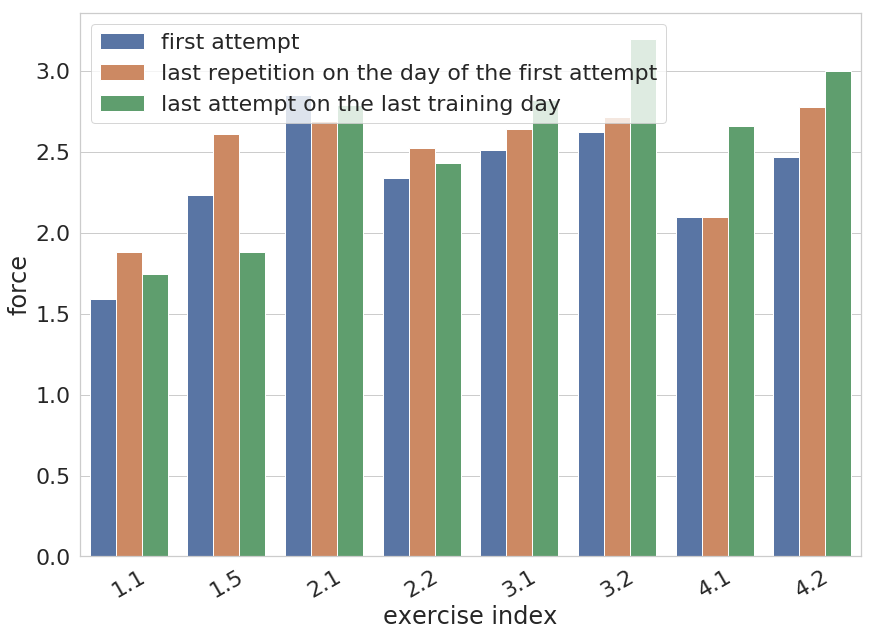

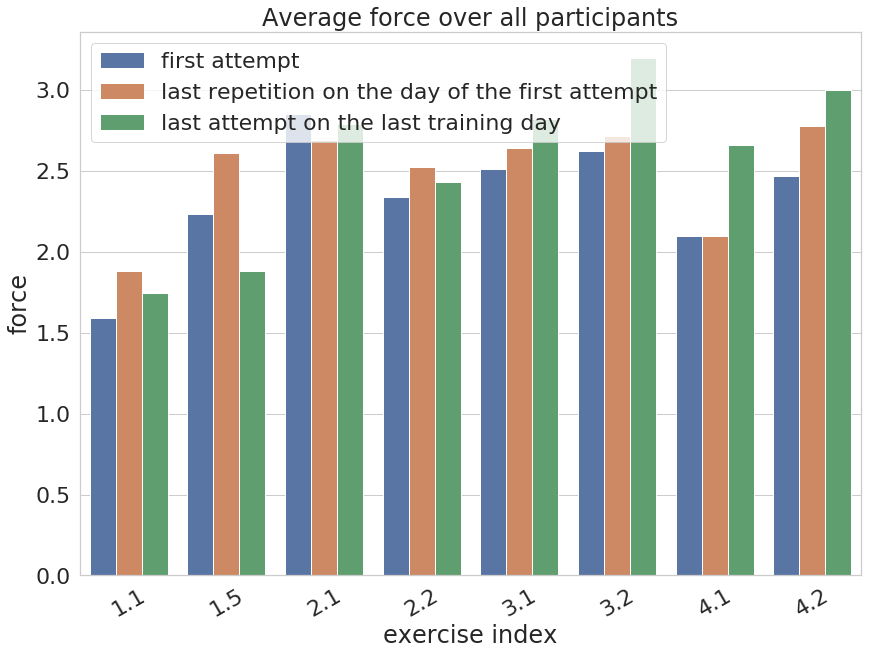

In [9]:
raw_data =  pd.read_csv('../data/step1_clear_data.csv')

with open('../data/parameter/ability_mapper.p', 'rb') as f:
    parameters = pickle.load(f)
print(parameters)
test_col, diff_def, n_class, group, _, if_merge_min, sampleing_rate = get_env_parameters()
test_col_name, test_file_name = get_test_col_name(test_col)
raw_data,_ = ability_level_mapper(raw_data, col=test_col, target_col_name='performance', parameters=parameters) 
raw_data = raw_data.groupby(['uid', 'day', 'exc_num', 'exc_times', 'difficulty']).mean()['performance'].reset_index()
# first_attempt = raw_data.groupby(['uid', 'exc_num']).head(1).reset_index()

raw_data = raw_data.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()['performance'].reset_index()

first_attempt = raw_data.groupby(['uid', 'exc_num']).head(1).reset_index()
last_attempt = raw_data.groupby(['uid', 'exc_num']).tail(1).reset_index()
print(first_attempt.loc[first_attempt.exc_num==3.2])
print(last_attempt.loc[last_attempt.exc_num==3.2])

last_repetition = raw_data.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)


last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'performance_y'], axis=1)
# print(last_repetition.head())
last_repetition.columns = ['day', 'uid', 'exc_num', 'performance']

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt on the last training day'
last_repetition['level'] = 'last repetition on the day of the first attempt'

cols = ['exc_num', 'level', 'performance']
df_tmp = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])
# print(df_tmp.head())

# draw figures
sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="performance", hue='level', ci=None, data=df_tmp)
# ax.set_title('Average velocity over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel=test_col_name)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/raw_'+test_file_name+'_avg.png')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="performance", hue='level', ci=None, data=df_tmp)
ax.set_title('Average '+test_col_name+' over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel=test_col_name)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/raw_'+test_file_name+'_avg_with_title.png')

# sns.set(font_scale=2)
# for index, group in uid_p.groupby(['uid']):
#     print(group)
#     tmp = group.reset_index(drop=True)
#     sns.set_style('whitegrid')
#     f, ax= plt.subplots(figsize = (14, 10))
#     ax = sns.barplot(x=tmp.index, y='theta', hue='exc_num', ci=None, data=tmp)
#     ax.set(xlabel='index')
#     ax.set(ylabel='performance')
#     plt.gca().legend().set_title('exercises')
#     f.savefig('../data/figure/velocity/theta_velocity_'+str(index)+'.png')
#     plt.show()

[Text(0.5,0,'participant index')]

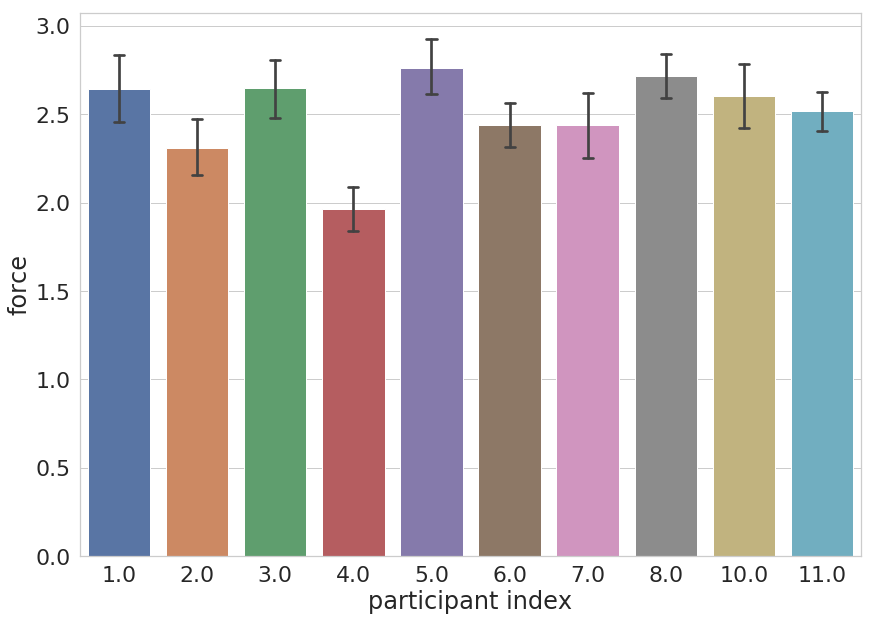

In [10]:
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="uid", y="performance", capsize=.13, data=raw_data)
# ax.set_title('Average velocity over all exercise for each participant')
ax.set(ylabel=test_col_name)
ax.set(xlabel='participant index')

### correlation between velocity before and after modeling

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3020: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


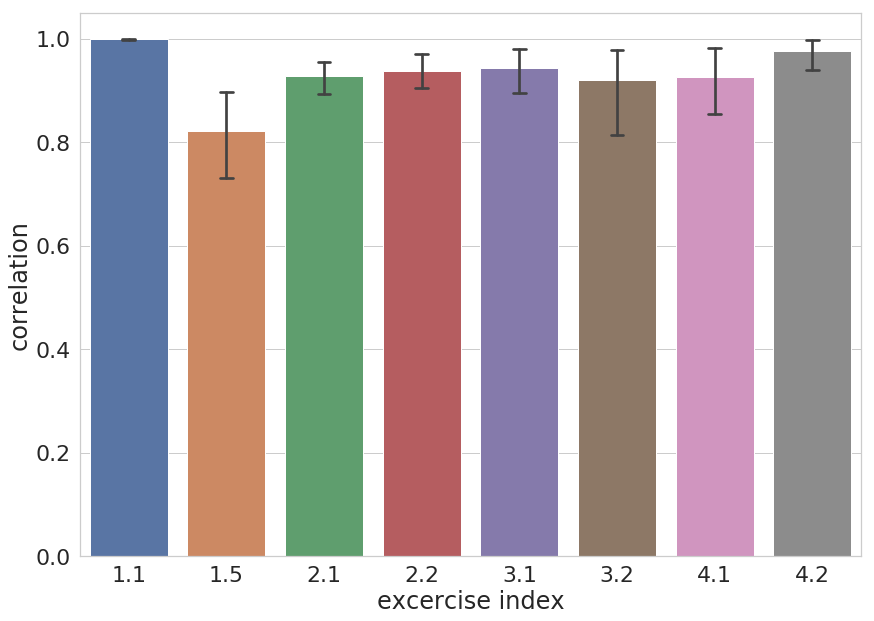

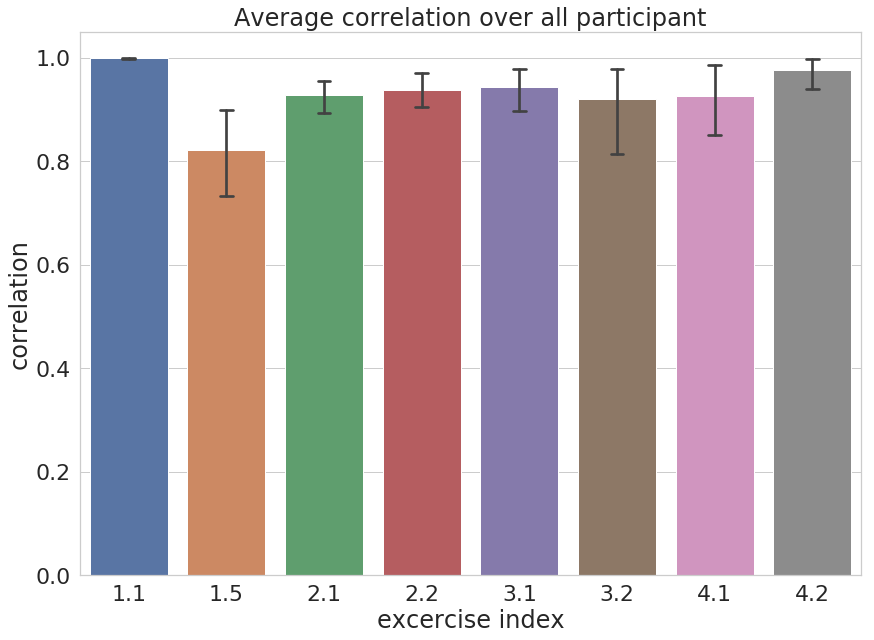

In [11]:
tmp = raw_data.merge(uid_p, on=['uid', 'day', 'exc_num', 'exc_times'], how='left')
df_tmp = pd.DataFrame()

for index, group in tmp.groupby(['uid', 'exc_num']):
    correlation = pearsonr(group['performance'], group['theta'])
    if len(group)<3:
        continue
#     print(correlation)
    tmp2 = pd.DataFrame(np.array(list(index)+list(correlation)).reshape(1,-1), 
                        columns=['uid','exc_num', 'correlation', 'p_value'])
    df_tmp = pd.concat([df_tmp, tmp2])
#     print(index)
#     print(len(group))
#     print(correlation)

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="correlation", capsize=.13, data=df_tmp)
# ax.set_title('Average correlation over all participant')
ax.set(ylabel='correlation')
ax.set(xlabel='excercise index')
f.savefig('../data/figure/all/'+test_file_name+'_correlation_before_after_modeling.png')


f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="correlation", capsize=.13, data=df_tmp)
ax.set_title('Average correlation over all participant')
ax.set(ylabel='correlation')
ax.set(xlabel='excercise index')
f.savefig('../data/figure/all/'+test_file_name+'_correlation_before_after_modeling_with_title.png')



### velocity figures

#### comparison between first and last attempt

    index  day   uid  exc_num  exc_times     theta
5      27  3.0   1.0      3.2        1.0 -1.240660
12     81  3.0   2.0      3.2        2.0 -1.654452
20    134  3.0   3.0      3.2        1.0 -1.228247
27    186  3.0   4.0      3.2        1.0 -2.921406
35    226  3.0   5.0      3.2        1.0 -1.553584
44    285  3.0   6.0      3.2        1.0 -1.116827
52    350  3.0   7.0      3.2        1.0 -0.987258
59    406  3.0   8.0      3.2        1.0 -1.380657
67    461  3.0  10.0      3.2        1.0 -0.978217
75    515  3.0  11.0      3.2        1.0 -1.459548
    index  day   uid  exc_num  exc_times     theta
5      56  5.0   1.0      3.2        2.0 -0.941949
13    103  5.0   2.0      3.2        2.0 -0.963783
20    160  5.0   3.0      3.2        3.0 -1.231001
28    203  5.0   4.0      3.2        2.0 -1.628057
36    253  5.0   5.0      3.2        2.0 -0.895930
44    313  5.0   6.0      3.2        2.0 -1.228082
52    378  5.0   7.0      3.2        2.0 -0.639127
59    434  5.0   8.0      3.2  

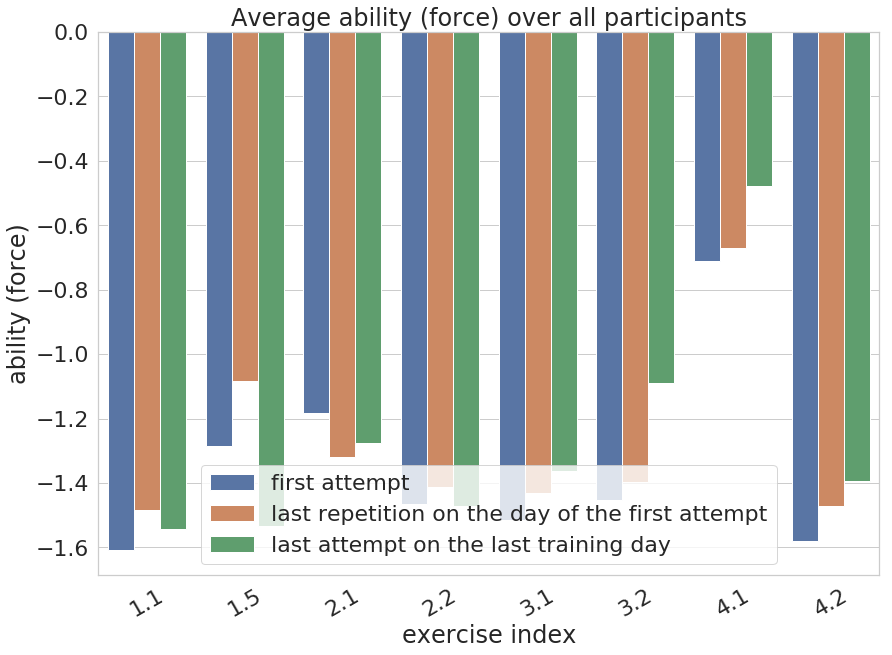

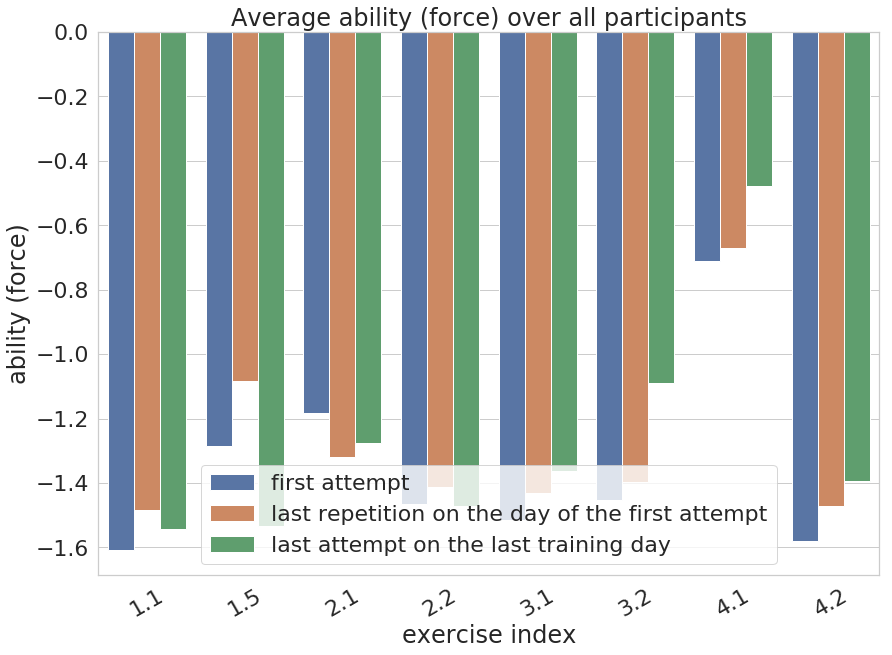

In [12]:
# find out first, last attempt and last repetition on the first day
first_attempt = uid_p.groupby(['uid', 'exc_num']).head(1).reset_index()
last_attempt = uid_p.groupby(['uid', 'exc_num']).tail(1).reset_index()
print(first_attempt.loc[first_attempt.exc_num==3.2])
print(last_attempt.loc[last_attempt.exc_num==3.2])

last_repetition = uid_p.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)

last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'theta_y'], axis=1)
last_repetition.columns = ['day', 'uid', 'exc_num', 'theta']

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt on the last training day'
last_repetition['level'] = 'last repetition on the day of the first attempt'

cols = ['exc_num', 'level', 'theta']
df_tmp = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])
# print(df_tmp.head())

# draw figures
sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", hue='level', ci=None, data=df_tmp)
ax.set_title('Average ability ('+test_col_name+') over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel='ability ('+test_col_name+')')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg.png')

sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", hue='level', ci=None, data=df_tmp)
ax.set_title('Average ability ('+test_col_name+') over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel='ability ('+test_col_name+')')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_with_title.png')



# sns.set(font_scale=2)
# for index, group in uid_p.groupby(['uid']):
#     print(group)
#     tmp = group.reset_index(drop=True)
#     sns.set_style('whitegrid')
#     f, ax= plt.subplots(figsize = (14, 10))
#     ax = sns.barplot(x=tmp.index, y='theta', hue='exc_num', ci=None, data=tmp)
#     ax.set(xlabel='index')
#     ax.set(ylabel='theta')
#     plt.gca().legend().set_title('exercises')
#     f.savefig('../data/figure/velocity/theta_velocity_'+str(index)+'.png')
#     plt.show()

#### variance over all exercises for each person

[Text(0.5,0,'participant index')]

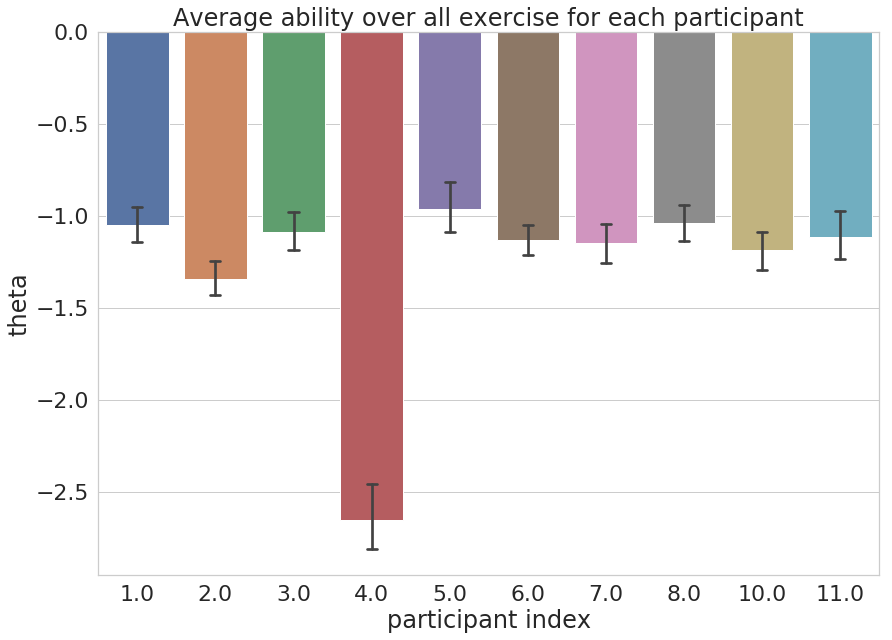

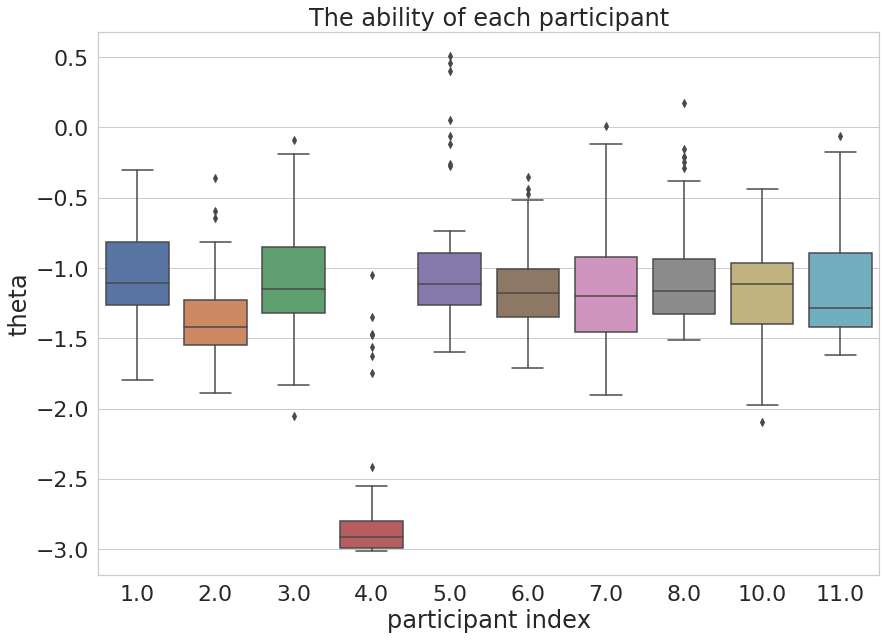

In [13]:
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="uid", y="theta", capsize=.13, data=uid_p)
ax.set_title('Average ability over all exercise for each participant')
ax.set(xlabel='participant index')
f.savefig('../data/figure/velocity/theta_velocity_avg_ability_barplot.png')

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="uid", y="theta", data=uid_p)
ax.set_title('The ability of each participant')
ax.set(xlabel='participant index')
# f.savefig('../data/figure/velocity/theta_velocity_avg_ability_boxplot.png')

### average ability over all participants on each training day

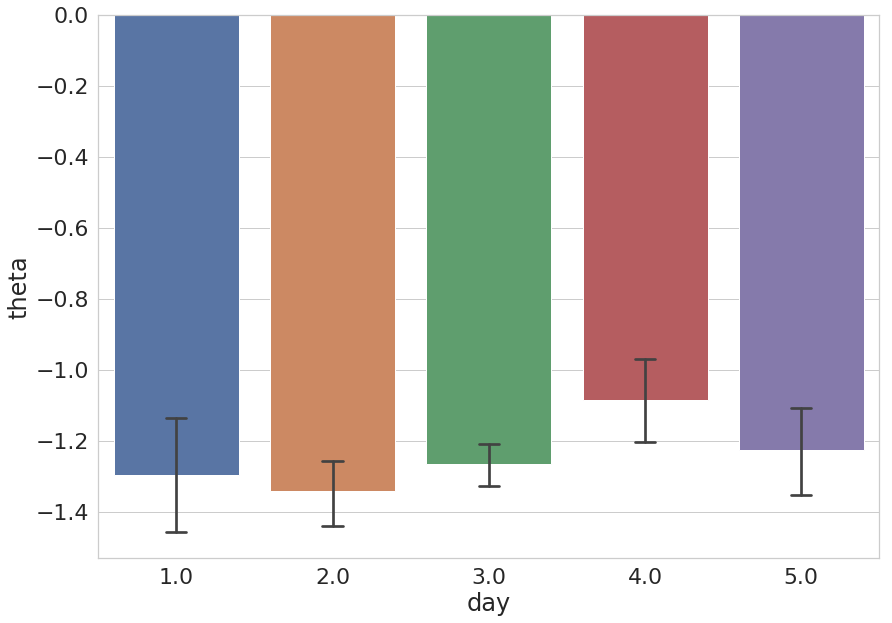

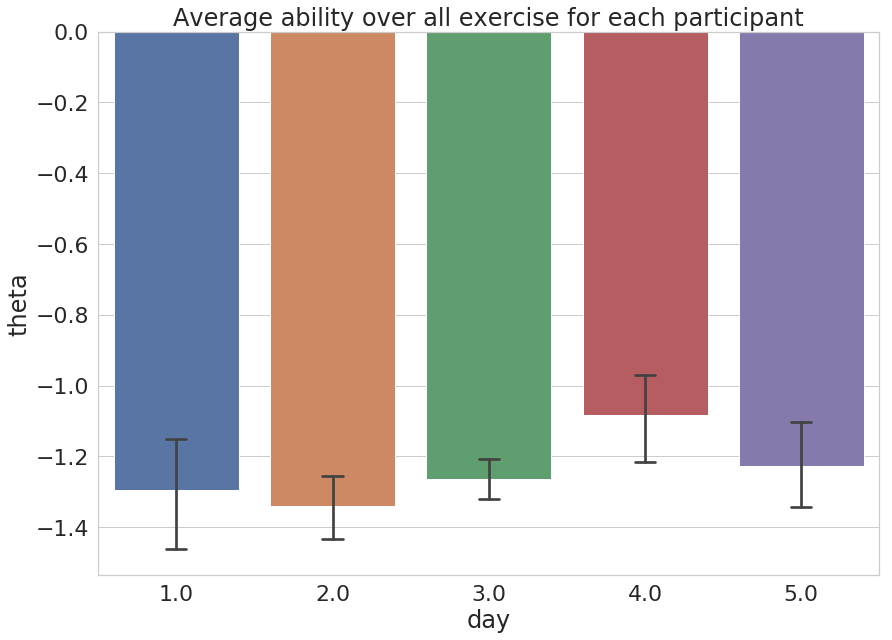

In [14]:
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, data=uid_p)
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_ability_barplot.png')

f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, data=uid_p)
ax.set_title('Average ability over all exercise for each participant')
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_ability_barplot_with_title.png')

#### deviation figures

In [15]:
# # find out first, last attempt and last repetition on the first day
# first_attempt = uid_p.groupby(['uid', 'exc_num']).head(1).reset_index()
# last_attempt = uid_p.groupby(['uid', 'exc_num']).tail(1).reset_index()

# last_repetition = uid_p.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
# last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)

# last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'theta_y'], axis=1)
# last_repetition.columns = ['day', 'uid', 'exc_num', 'theta']

# first_attempt['level'] = 'first attempt'
# last_attempt['level'] = 'last attempt on the last training day'
# last_repetition['level'] = 'last repetition on the day of the first attempt'

# cols = ['exc_num', 'level', 'theta']
# df_tmp = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])
# print(df_tmp.head())

# # draw figures
# sns.set(font_scale=2)
# sns.set_style('whitegrid')

# f, ax= plt.subplots(figsize = (14, 10))

# ax = sns.barplot(x="exc_num", y="theta", hue='level', ci=None, data=df_tmp)
# ax.set_title('Average ability(deviation) over all participant')
# ax.set(xlabel='exercise index')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# plt.gca().legend().set_title('')
# f.savefig('../data/figure/deviation/theta_deviation_avg.png')



# sns.set(font_scale=2)
# for index, group in uid_p.groupby(['uid']):
#     print(group)
#     tmp = group.reset_index(drop=True)
#     sns.set_style('whitegrid')
#     f, ax= plt.subplots(figsize = (14, 10))
#     ax = sns.barplot(x=tmp.index, y='theta', hue='exc_num', ci=None, data=tmp)
#     ax.set(xlabel='index')
#     ax.set(ylabel='theta (velocity)')
#     plt.gca().legend().set_title('exercises')
#     f.savefig('../data/figure/deviation/theta_deviation_'+str(index)+'.png')
#     plt.show()

In [16]:
# sns.set_style('whitegrid')

# f, ax= plt.subplots(figsize = (14, 10))

# ax = sns.barplot(x="uid", y="theta", capsize=.13, data=uid_p)
# ax.set_title('Average ability(deviation) over all exercise for each participant')
# ax.set(xlabel='participant index')
# f.savefig('../data/figure/deviation/theta_deviation_avg_ability_barplot.png')

# sns.set_style('whitegrid')
# f, ax= plt.subplots(figsize = (14, 10))

# ax = sns.boxplot(x="uid", y="theta", data=uid_p)
# ax.set_title('The ability(deviation) of each participant')
# ax.set(xlabel='participant index')
# f.savefig('../data/figure/deviation/theta_deviation_avg_ability_boxplot.png')

## test

### online test

In [17]:
# test_data = pd.read_csv('../data/step1_clear_data.csv')
# performance_data = pd.read_csv('../data/step2_expected_performance.csv')
# with open('../data/parameter/ability_mapper.p', 'rb') as f:
#     parameters = pickle.load(f)
# test_col, diff_def, n_class, group, _, if_merge_min, sampleing_rate = get_env_parameters()
# test_data,_ = ability_level_mapper(test_data, col=test_col, target_col_name='performance', parameters=parameters) 
# tmp1 = find_segment(test_data, cols=['uid', 'day','exc_num', 'exc_times'], values=[1, 3, 3.2, 1])
# tmp2 = find_segment(test_data, cols=['uid', 'day','exc_num', 'exc_times'], values=[1, 5, 3.2, 2])
# test_data = pd.concat([tmp1, tmp2])
# test_data = test_data.groupby(['uid', 'day', 'exc_num', 'exc_times', 'difficulty']).mean()['performance'].reset_index()
# print(test_data)
# tmp1 = find_segment(all_data, cols=['uid', 'day','exc_num', 'exc_times'], values=[1, 3, 3.2, 1])
# tmp2 = find_segment(all_data, cols=['uid', 'day','exc_num', 'exc_times'], values=[1, 5, 3.2, 2])
# test_data = pd.concat([tmp1, tmp2])
# print(test_data)

### average difference between model processed data and model parameter estimates

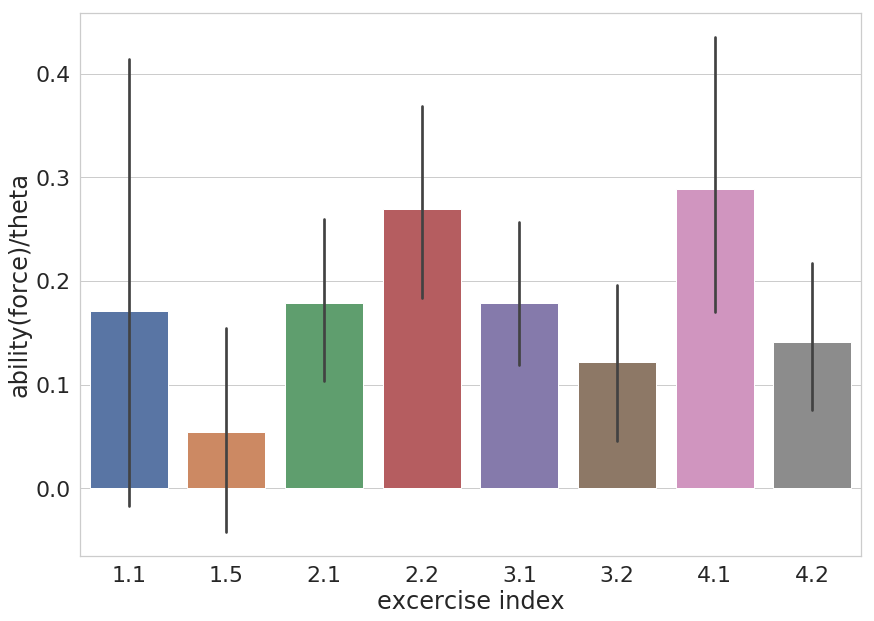

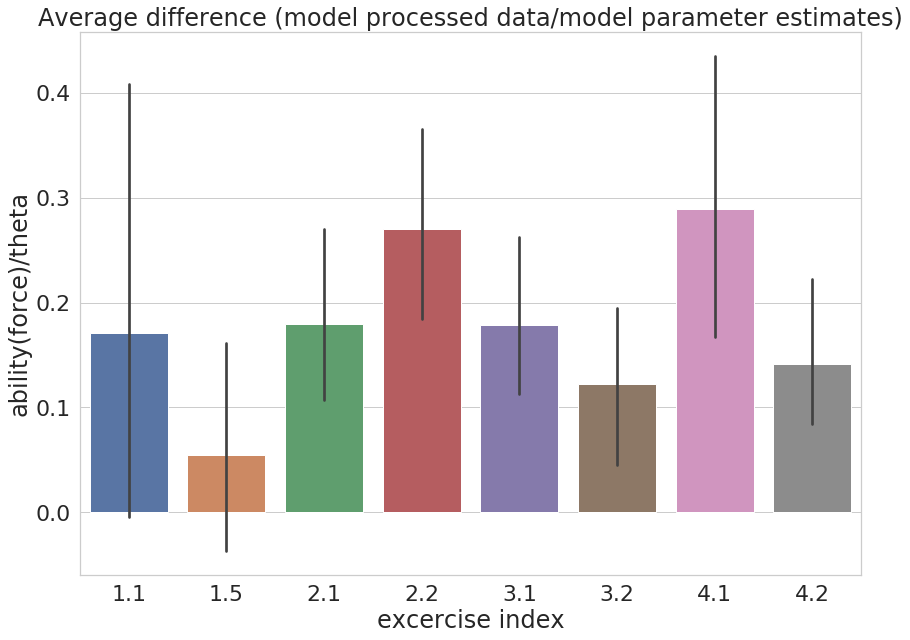

In [18]:
kwargs = {"length": 5000}
ability = calc_test_theta(all_data, cl, exc_p, user_by=['uid', 'day', 'exc_num', 'exc_times']
                          , item_by=['difficulty'], **kwargs)
result = ability.set_index(['uid', 'day', 'exc_num', 'exc_times']) - \
    uid_p.set_index(['uid', 'day', 'exc_num', 'exc_times'])
result = result.reset_index()
# print('average theta:', result)
# print(result)

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", data=result)
ax.set(xlabel='excercise index')
ax.set(ylabel='ability('+test_col_name+')/theta')
f.savefig('../data/figure/all/difference_processed_and_estimates_'+test_file_name+'_.png')

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", data=result)
ax.set_title('Average difference (model processed data/model parameter estimates)')
ax.set(xlabel='excercise index')
ax.set(ylabel='ability('+test_col_name+')/theta')
f.savefig('../data/figure/all/difference_processed_and_estimates_'+test_file_name+'_with_title.png')

In [19]:
# tmp = ability.set_index(['uid', 'day', 'exc_num', 'exc_times'])-uid_p.loc[uid_p.uid==1]. \
#     set_index(['uid', 'day', 'exc_num', 'exc_times'])
# tmp = tmp.reset_index()

# tmp.groupby(['exc_num'])['theta'].mean()

In [20]:
ability = calc_test_theta(test, cl, exc_p, item_by=[], 
                          user_by=['uid', 'day', 'exc_num', 'exc_times', 'difficulty'], **kwargs)
min_perf = ability['theta'].min()
max_perf = ability['theta'].max()
tmp2 = ability.groupby(['uid', 'day', 'exc_num', 'exc_times'])['theta'].std()/(max_perf-min_perf)
tmp2 = tmp2.reset_index()
tmp2['theta'].mean()

AttributeError: 'NoneType' object has no attribute 'groupby'

In [ ]:
tmp = all_data.loc[all_data.uid==test_uid]
# print(tmp)
min_perf = tmp['performance'].min()
max_perf = tmp['performance'].max()
tmp1 = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times'])['performance'].std()/(max_perf-min_perf)
tmp1 = tmp1.reset_index()
tmp1['performance'].mean()

In [ ]:
if 'level' not in tmp2.columns:
    tmp2.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
    tmp1.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
tmp2['level'] = 'with modeling'
tmp1['level'] = 'without modeling'
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv('../data/diff_std_theta_uid8.csv')
# print(tmp)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
ax.set_title('Standard deviation over difficulties for each exercise on the test data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/velocity/diff_std_theta_barplot.png')


In [ ]:
ability = calc_test_theta(all_data, cl, exc_p, item_by=[], 
                          user_by=['uid', 'day', 'exc_num', 'exc_times', 'difficulty'], **kwargs)
min_perf = ability['theta'].min()
max_perf = ability['theta'].max()
tmp2 = ability.groupby(['uid', 'day', 'exc_num', 'exc_times'])['theta'].std()/(max_perf-min_perf)
tmp2 = tmp2.reset_index()
tmp2['theta'].mean()

In [ ]:
tmp = all_data.loc[all_data.uid!=test_uid]
# print(tmp)
min_perf = tmp['performance'].min()
max_perf = tmp['performance'].max()
tmp1 = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times'])['performance'].std()/(max_perf-min_perf)
tmp1 = tmp1.reset_index()
tmp1['performance'].mean()

In [ ]:
if 'level' not in tmp2.columns:
    tmp2.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
    tmp1.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
tmp2['level'] = 'with modeling'
tmp1['level'] = 'without modeling'
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv('../data/diff_std_theta_uid8.csv')
# print(tmp)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
ax.set_title('Standard deviation over difficulties for each exercise on the training data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/velocity/diff_std_theta_train_barplot.png')


### ability estimation for a certain exercise

In [ ]:
# all_data = pd.read_csv('../data/step1_clear_data.csv')
# # performance_data = pd.read_csv('../data/step2_expected_performance.csv')
# selected_uid_day_exc_times = (1, 1, 1.1, 2)
# selected_data = all_data.set_index(['uid', 'day', 'exc_num', 'exc_times']).loc[selected_uid_day_exc_times]   

# test_col, diff_def, n_class, group, _, if_merge_min, sampleing_rate = get_env_parameters()

In [ ]:
# def estimate_ability(data, performance_data, exc_p, test_col, cl):
# #     print(data.head(1))
#     abi = data[['front', 'difficulty']]
# #     print(abi.head())
#     abi['b'] = abi.apply(lambda x: exc_p.loc[exc_p.difficulty==x['difficulty'], 'b'].values[0], axis=1)
#     abi = abi.reset_index()
#     with open('../data/parameter/ability_mapper.p', 'rb') as f:
#         parameters = pickle.load(f)
#     abi,_ = ability_level_mapper(abi, col=test_col, target_col_name=test_col, parameters=parameters)
    
#     def get_abi(x):
#         if x[test_col] == 20:
#             return 4
#         elif x[test_col] ==1:
#             return -4
#         else:
#             return x['b']-(cl[int(x[test_col])-2]+ cl[int(x[test_col]-1)])
                           
                           
#     abi['abi'] = abi.apply(get_abi, axis=1)
#     return abi

def estimate_ability(df, diff_df, test_col, cl, by=['day', 'uid', 'exc_num', 'exc_times']):
    # 1. calculate difficulty for df
    # 1.1 in our proceesed data, there is already difficulty in it
    if 'difficulty' in df.columns:
        
    # 2. calculate performance for df
    # 2.1 load param. from file
        with open('../data/parameter/ability_mapper.p', 'rb') as f:
            parameters = pickle.load(f)
        df, _ = ability_level_mapper(df, col=test_col, target_col_name=test_col, parameters=parameters)
        print(2)
        
    # 3. merge df and diff_df to get parameter of difficulty
        print(len(df))
        df = df.merge(diff_df, on=['difficulty'])
        print(len(df))
        print(3)
        
    # 4. find c from cl with usage of perf. calculate ability according to diff param. and c.
        def get_abi(x):
            if x[test_col] == 20:
                return 4
            elif x[test_col] ==1:
                return -4
            else:
                return x['b']-(cl[int(x[test_col])-2]+ cl[int(x[test_col]-1)])
        
        %timeit df['ability'] = df.apply(get_abi, axis=1)
        print(4)
        
    # summary
    # 1. calc std in each group for ability, and describe them
    print('warning: you use default group unit')
    summary = df.groupby(['day', 'uid', 'exc_num', 'exc_times']).std()['ability']
    print(summary.describe())
    # 2. find out the 5 worst group with large std
    worst = summary.sort_values().tail(5).reset_index()
    worst.columns = ['day', 'uid', 'exc_num', 'exc_times', 'std']
    print(worst)
    del summary
    return df
        

In [ ]:
ability = estimate_ability(all_data ,exc_p, test_col, cl)
# sns.set_style('whitegrid')
# f, ax= plt.subplots(figsize = (14, 10))
# ax = sns.lineplot(x=ability.index, y='abi', data=ability)
# plt.show()

In [ ]:
delta.loc[(delta[col]<grad_thres) & (delta[col]>0), col] + grad_thres

In [ ]:
# tmp = expected_performance.groupby(['exc_num', 'difficulty'])['performance'].mean().reset_index()
# tmp.to_csv('../data/exc_difficulty.csv', index=False)